In [1]:
print("Importing Libraries ...", end = " ")
try:
    import numpy as np
    import pandas as pd
    import random
    import h5py
    import time
    import mne
    import csv
    import os
    from sklearn.preprocessing import scale, minmax_scale, StandardScaler
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.ensemble import BaggingClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn import model_selection, svm, metrics
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.utils import shuffle
    from scipy.signal import butter, lfilter, freqz
    from datetime import datetime, timedelta
    from matplotlib.patches import Rectangle
    from matplotlib import pyplot as plt
    from scipy.stats import skew, kurtosis
    from scipy import fftpack
    from scipy import signal
    import pywt
    
    import tensorflow as tf
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
    from model_dtct_feat import get_model
    from model_dtct_reeg import get_model_reeg
    from model_dtct_cnn_feat import get_model_cnn_feat
    from model_dtct_cnn_reeg import get_model_cnn_reeg
    print("Done!\n")
except Exception as e:
    print("Failed to import one or more packages!\n")
    print(e)
    
print(tf.config.list_physical_devices("GPU"))
print(tf.__version__)

Importing Libraries ... 

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2024-11-19 11:13:56.103030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 11:13:57.004986: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 11:13:58.477748: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lclhome/umoha

Failed to import one or more packages!

No module named 'model_dtct_feat'
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


In [2]:
def butterworth_lowpass_filter(signal_data, sampling_rate = 256.0, cutoff_frequency = 127.0, filter_order = 5):
    # Convert cutoff frequency to normalized digital frequency
    normalized_cutoff = 2 * cutoff_frequency / sampling_rate

    # Design the Butterworth low-pass filter
    b, a = butter(filter_order, normalized_cutoff, btype='low', analog=False)
    
    filtered_signal = np.zeros(signal_data.shape)
    # Apply the filter to the signal
    for i in range(signal_data.shape[0]):
        #print(i+1, end = " ")
        filtered_signal[i,:] = lfilter(b, a, signal_data[i,:])

    return filtered_signal

In [3]:
def butterworth_bandpass_filter(signal_data, sampling_rate = 256.0, cutoff_frequency = [0.5, 127.0], filter_order = 5):
    # Convert cutoff frequency to normalized digital frequency
    normalized_cutoff_1 = 2 * cutoff_frequency[0] / sampling_rate
    normalized_cutoff_2 = 2 * cutoff_frequency[0] / sampling_rate
    normalized_cutoff = [normalized_cutoff_1, normalized_cutoff_2]
    
    # Design the Butterworth low-pass filter
    b, a = butter(filter_order, normalized_cutoff, btype='pass', analog=False)
    
    filtered_signal = np.zeros(signal_data.shape)
    # Apply the filter to the signal
    for i in range(signal_data.shape[0]):
        #print(i+1, end = " ")
        filtered_signal[i,:] = lfilter(b, a, signal_data[i,:])

    return filtered_signal

In [4]:
def fft_mit(x, fs): 
    N = len(x) # find the length of the signal
    X_fft = fftpack.fft(x) # perform the fast Fourier transform (fft)
    X_fft_shifted = fftpack.fftshift (X_fft) # shift zero frequency components
    freq = np.arange (-N/2, N/2)*fs/N # compute the frequencies for the output
    X_mag = np.abs( X_fft_shifted )/N # compute the magnitudes of the signal
    X_phi = np. angle ( X_fft_shifted ) # compute the phases of the signal
    # ----- End of user defined function ----- #
    return freq, X_mag, X_phi

In [5]:
def make_stem (ax ,x,y, color ='k',style ='solid',label ='',linewidths =2.5 ,** kwargs ):
    ax. axhline (x[0] ,x[ -1] ,0 , color ='r')
    ax. vlines (x, 0 ,y, color =color , linestyles =style , label =label , linewidths = linewidths )
    ax. set_ylim ([1.05* y. min () , 1.05* y. max () ])
def list_mean(list_1):
    return sum(list_1)/len(list_1)

In [6]:
def return_feature_list(array_work, samp_rate = 256, num_of_channels = 20):
    total_feature_list = []
    for ch_count in range(num_of_channels):
        freq, X_mag, _ = fft_mit(array_work[:,ch_count], fs = samp_rate)
        total_mags = 8
        mag_ratios = 7
        total_mag_ratios = total_mags+mag_ratios*total_mags
        half_idx = len(X_mag)//2
        bin_size = half_idx//8 
        mag_list = [0]*total_mags
        mag_list_ratios = [0]*total_mag_ratios
        for ii in range(total_mags):
            strt_idx = half_idx+ii*bin_size
            ends_idx = strt_idx+bin_size
            mean_spectrum = np.mean(X_mag[strt_idx:ends_idx])
            mag_list[ii] = mean_spectrum 
            mag_list_ratios[ii] = mean_spectrum
        for ii in range(total_mags):
            counts = 0
            for jj in range(total_mags):
                if not ii == jj:
                    ratio_of_mags = mag_list[ii]/(mag_list[jj]+np.finfo(float).eps)
                    curr_idx = total_mags+ii*mag_ratios+counts
                    mag_list_ratios[curr_idx] = ratio_of_mags
                    counts+=1
        mag_list_ratios.append(np.mean(array_work[:,0]))
        mag_list_ratios.append(np.var(array_work[:,0]))

        wvlt = pywt.wavedec(array_work[:,0], 'db5', mode='sym', level=4)
        for ii in range(len(wvlt)):
            mag_list_ratios.append(np.mean(wvlt[ii]))
    
        total_feature_list += mag_list_ratios
    return(total_feature_list)

In [7]:
def print_and_plot_metrics(res_path, dat_path, patient_list, beta = 20, mtype = "res", dtype = "feat"):
    
    
    metrics_dict_train = {"roc": [], "acc": [], "spe": [], "sen": [], "pre": [], "fpr": [], "f1s": [], "fbs": []}
    metrics_dict_valid = {"roc": [], "acc": [], "spe": [], "sen": [], "pre": [], "fpr": [], "f1s": [], "fbs": []}
    metrics_dict_tests = {"roc": [], "acc": [], "spe": [], "sen": [], "pre": [], "fpr": [], "f1s": [], "fbs": []}
    metrics_dict_tests = {"roc": [], "acc": [], "spe": [], "sen": [], "pre": [], "fpr": [], "f1s": [], "fbs": [], 
                          "fpr_list": [], "tpr_list": []}

    fig, ax = plt.subplots(4, 4)
    fig.set_size_inches(12, 8)

    print(f"******************************************************** Test Metrics "
          f"********************************************************")
    print(f"ID \tROC-AUC \tAccuracy \tSpecificity \tSensitivity \tPrecision \tFPR \t  F-1 \t\t F-beta")  
    for iterator in range(len(patient_list)):
        pat_id = patient_list[iterator]
        ii = iterator//4
        jj = iterator%4
        #pat_key = f"chb{pat_id:02d}"
        pat_key = pat_id
        ### print(f"*********************** {pat_key} ***********************")
        ### print(f"Processing {pat_key}", end ="\r")

        y_prob_train = np.load(f'{res_path}{pat_key}_trn_dtct_{mtype}_{dtype}_output.npy')
        y_prob_valid = np.load(f'{res_path}{pat_key}_vld_dtct_{mtype}_{dtype}_output.npy')
        y_prob_tests = np.load(f'{res_path}{pat_key}_vld_dtct_{mtype}_{dtype}_output.npy')
        y_true_train = pd.read_csv(f'{dat_path}{pat_key}_srate256hz_wlen5s_trn_labs.csv',header=None).values
        y_true_valid = pd.read_csv(f'{dat_path}{pat_key}_srate256hz_wlen5s_vld_labs.csv',header=None).values
        y_true_tests = pd.read_csv(f'{dat_path}{pat_key}_srate256hz_wlen5s_vld_labs.csv',header=None).values

        fpr_list_train, tpr_list_train, thr_list_train = metrics.roc_curve(y_true_train,y_prob_train)
        pre_list_train, rec_list_train, thr_list_train = metrics.precision_recall_curve(y_true_train, y_prob_train)
        f1_score_train = (1+beta**2) * (pre_list_train * rec_list_train) / ((pre_list_train*beta**2) + 
                                                                            rec_list_train + np.finfo(float).eps)

 

        f1_max_ind_train = np.argmax(f1_score_train)
        if mtype == "res":
            threshold_train = thr_list_train[f1_max_ind_train]
        else:
            # threshold_train = thr_list_train[2]
            threshold_train = 0.5
        threshold_train = 0.5
        y_pred_train = y_prob_train >= threshold_train
        

        cm = metrics.confusion_matrix(y_true_train,y_pred_train)
        tp_list_train = cm[1,1]
        fp_list_train = cm[0,1]
        tn_list_train = cm[0,0]
        fn_list_train = cm[1,0]
    
        acc_train = sum(sum(y_true_train == y_pred_train))/len(y_true_train)
        spe_train = tn_list_train/(tn_list_train+fp_list_train)
        sen_train = tp_list_train/(tp_list_train+fn_list_train)
        pre_train = tp_list_train/(tp_list_train+fp_list_train)
        fpr_train = fp_list_train/(tn_list_train+fp_list_train)
        roc_train = metrics.roc_auc_score(y_true_train, y_prob_train)
        f1s_train = 2 * (pre_train * sen_train) / (pre_train + sen_train + np.finfo(float).eps)
        fbs_train = (1+beta**2) * (pre_train * sen_train) / ((pre_train*beta**2) + sen_train + np.finfo(float).eps)
        metrics_dict_train["roc"].append(roc_train)
        metrics_dict_train["acc"].append(acc_train)
        metrics_dict_train["spe"].append(spe_train)
        metrics_dict_train["sen"].append(sen_train)
        metrics_dict_train["pre"].append(pre_train)
        metrics_dict_train["fpr"].append(fpr_train)
        metrics_dict_train["f1s"].append(f1s_train)
        metrics_dict_train["fbs"].append(fbs_train)

        fpr_list_valid, tpr_list_valid, thr_list_valid = metrics.roc_curve(y_true_valid,y_prob_valid)
        pre_list_valid, rec_list_valid, thr_list_valid = metrics.precision_recall_curve(y_true_valid, y_prob_valid)
        f1_score_valid = (1+beta**2) * (pre_list_valid * rec_list_valid) / ((pre_list_valid*beta**2) + 
                                                                            rec_list_valid + np.finfo(float).eps)
        f1_max_ind_valid = np.argmax(f1_score_valid)
        if mtype == "res" or mtype == "cnn":
            threshold_valid = thr_list_valid[f1_max_ind_valid]
        else:
            # threshold_valid = thr_list_valid[2]
            threshold_valid = 0.5
        #threshold_valid = 0.5
        y_pred_valid = y_prob_valid >= threshold_valid
        cm = metrics.confusion_matrix(y_true_valid,y_pred_valid)
        tp_list_valid = cm[1,1]
        fp_list_valid = cm[0,1]
        tn_list_valid = cm[0,0]
        fn_list_valid = cm[1,0]


        acc_valid = sum(sum(y_true_valid == y_pred_valid))/len(y_true_valid)
        spe_valid = tn_list_valid/(tn_list_valid+fp_list_valid)
        sen_valid = tp_list_valid/(tp_list_valid+fn_list_valid)
        pre_valid = tp_list_valid/(tp_list_valid+fp_list_valid)
        fpr_valid = fp_list_valid/(tn_list_valid+fp_list_valid)
        roc_valid = metrics.roc_auc_score(y_true_valid, y_prob_valid)
        f1s_valid = 2 * (pre_valid * sen_valid) / (pre_valid + sen_valid + np.finfo(float).eps)
        fbs_valid = (1+beta**2) * (pre_valid * sen_valid) / ((pre_valid*beta**2) + sen_valid + np.finfo(float).eps)
    
        metrics_dict_valid["roc"].append(roc_valid)
        metrics_dict_valid["acc"].append(acc_valid)
        metrics_dict_valid["spe"].append(spe_valid)
        metrics_dict_valid["sen"].append(sen_valid)
        metrics_dict_valid["pre"].append(pre_valid)
        metrics_dict_valid["fpr"].append(fpr_valid)
        metrics_dict_valid["f1s"].append(f1s_valid)
        metrics_dict_valid["fbs"].append(fbs_valid)
    
        fpr_list_tests, tpr_list_tests, thr_list_tests = metrics.roc_curve(y_true_tests,y_prob_tests)
        pre_list_tests, rec_list_tests, thr_list_tests = metrics.precision_recall_curve(y_true_tests, y_prob_tests)
        f1_score_tests = (1+beta**2) * (pre_list_tests * rec_list_tests) / ((pre_list_tests*beta**2) + 
                                                                            rec_list_tests + np.finfo(float).eps)
        f1_max_ind_tests = np.argmax(f1_score_tests)
        #threshold_tests = thr_list_tests[f1_max_ind_tests]
        threshold_tests = threshold_valid
        y_pred_tests = y_prob_tests >= threshold_tests
        cm = metrics.confusion_matrix(y_true_tests,y_pred_tests)
        tp_list_tests = cm[1,1]
        fp_list_tests = cm[0,1]
        tn_list_tests = cm[0,0]
        fn_list_tests = cm[1,0]
    
        acc_tests = sum(sum(y_true_tests == y_pred_tests))/(len(y_true_tests) + np.finfo(float).eps)
        spe_tests = tn_list_tests/(tn_list_tests+fp_list_tests + np.finfo(float).eps)
        sen_tests = tp_list_tests/(tp_list_tests+fn_list_tests + np.finfo(float).eps)
        pre_tests = tp_list_tests/(tp_list_tests+fp_list_tests + np.finfo(float).eps)
        fpr_tests = fp_list_tests/(tn_list_tests+fp_list_tests + np.finfo(float).eps)
        roc_tests = metrics.roc_auc_score(y_true_tests, y_prob_tests)
        f1s_tests = 2 * (pre_tests * sen_tests) / (pre_tests + sen_tests + np.finfo(float).eps)
        fbs_tests = (1+beta**2) * (pre_tests * sen_tests) / ((pre_tests*beta**2) + sen_tests + np.finfo(float).eps)
    
        metrics_dict_tests["roc"].append(roc_tests)
        metrics_dict_tests["acc"].append(acc_tests)
        metrics_dict_tests["spe"].append(spe_tests)
        metrics_dict_tests["sen"].append(sen_tests)
        metrics_dict_tests["pre"].append(pre_tests)
        metrics_dict_tests["fpr"].append(fpr_tests)
        metrics_dict_tests["f1s"].append(f1s_tests)
        metrics_dict_tests["fbs"].append(fbs_tests)
        metrics_dict_tests["fpr_list"].append(fpr_list_tests)
        metrics_dict_tests["tpr_list"].append(tpr_list_tests)
        
        ax[ii, jj].plot(fpr_list_train, tpr_list_train, 'k:')
        ax[ii, jj].plot(fpr_list_valid, tpr_list_valid, 'r-.')
        ax[ii, jj].plot(fpr_list_tests, tpr_list_tests, 'b-')
        ax[ii, jj].set_title(f'{pat_key}')
        ax[ii, jj].set_xlabel('FPR')
        ax[ii, jj].set_ylabel('TPR')
        ax[ii,jj].set_xlim([0-0.01,1+0.01])
        ax[ii,jj].set_ylim([0-0.01,1+0.01])
        ax[ii,jj].set_xticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii,jj].set_yticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii, jj].grid()
    
        print('{:s}'.format((pat_key[-2:])), end = " ")
        print('\t{:6.2f}%'.format(100*roc_tests), end = " ")
        print('\t{:6.2f}%'.format(100*acc_tests), end = " ")
        print('\t{:6.2f}%'.format(100*spe_tests), end = " ")
        print('\t{:6.2f}%'.format(100*sen_tests), end = " ")
        print('\t{:6.2f}%'.format(100*pre_tests), end = " ")
        print('     {:6.2f}%'.format(100*fpr_tests), end = " ")
        print('\t{:6.2f}%'.format(100*f1s_tests), end = " ")
        print('\t{:6.2f}%'.format(100*fbs_tests), end = " ")
        print()

    metrics_dict_tests["roc"].append(list_mean(metrics_dict_tests["roc"]))
    metrics_dict_tests["acc"].append(list_mean(metrics_dict_tests["acc"]))
    metrics_dict_tests["spe"].append(list_mean(metrics_dict_tests["spe"]))
    metrics_dict_tests["sen"].append(list_mean(metrics_dict_tests["sen"]))
    metrics_dict_tests["pre"].append(list_mean(metrics_dict_tests["pre"]))
    metrics_dict_tests["fpr"].append(list_mean(metrics_dict_tests["fpr"]))
    metrics_dict_tests["f1s"].append(list_mean(metrics_dict_tests["f1s"]))
    metrics_dict_tests["fbs"].append(list_mean(metrics_dict_tests["fbs"]))
    print('{:s}'.format("Avgs."), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["roc"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["acc"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["spe"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["sen"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["pre"][-1]), end = " ")
    print('     {:6.2f}%'.format(100*metrics_dict_tests["fpr"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["f1s"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["fbs"][-1]), end = " ")
    print()
    print()
    print("ROC curves:")
    #ax[ii, jj].legend(["Train", "Valid", "Test"], loc = 'lower right')
    plt.figlegend(["Train", "Valid", "Test"], loc = 8, ncol=5, labelspacing=0.)
    fig.tight_layout()
    plt.show()
   
    return metrics_dict_train.copy(), metrics_dict_valid.copy(), metrics_dict_tests.copy()

In [8]:
def pred_print_and_plot_metrics(results_path, data_path, patient_list, leads_seiz_used_inds_dict,
                                beta = 20, mtype = "res", dtype = "feat"):
    
    metrics_dict_tests = {"roc": [], "acc": [], "spe": [], "sen": [], "pre": [], "fpr": [], "f1s": [], "fbs": [], 
                          "fpr_list": [], "tpr_list": []}

    print(f"******************************************************** Test Metrics "
          f"********************************************************")
    print(f"ID/Seiz ROC-AUC \tAccuracy \tSpecificity \tSensitivity \tPrecision \tFPR \t  F-1 \t\t F-beta")  
    
    for cur_pat_id in patient_list:
        pass
    for i in range(num_of_bmrks):
        benchmark_id = bnchmrk_names_list[i]
        #npy_file_dirs_dict[benchmark_id] = []
        sph_len_mins = benchmark_tot_list[i][0]
        sop_len_mins = benchmark_tot_list[i][1]
        gap_len_mins = sph_len_mins + sop_len_mins
        f07_bmrk_idnm_strg = benchmark_id # "bmrk{:02d}".format(benchmark_id)
        f08_spht_secs_strg = "sph{:02d}m".format(sph_len_mins)
        f09_sopt_secs_strg = "sop{:02d}m".format(sop_len_mins)
        benchmark_prefix = (f"{f07_bmrk_idnm_strg}_{f08_spht_secs_strg}_{f09_sopt_secs_strg}_"
                            f"{f10_segs_lens_strg}_{f11_over_stat_strg}")
        #print(f"{prefix_unsc_rand}_{benchmark_prefix}_{valid_labels_suffix}")
    
        for j in range(1):
            valid_seizure_number = j
            vald_seiz_strg = f07_bmrk_idnm_strg
            dkey = f07_bmrk_idnm_strg
            #rint('----------------------------------------------- Printing for seizure No {:02d}'.format(
            #   valid_seizure_number),
            #      '-----------------------------------------------'), labs_labl_strg, labs_frmt_strg)
        
            trn_vals_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{train_values_suffix}"
            trn_labs_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{train_labels_suffix}"
            vld_vals_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{valid_values_suffix}"
            vld_labs_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{valid_labels_suffix}"
        
            vld_labs_fpath =  pth_upl+vld_labs_fname
            y_prob_tests = np.load(f'{results_path}{dkey}_cset_{vald_seiz_strg:s}_tst_pred_{dtype}_{mtype}_output.npy')
            #print(f'{results_path}{dkey}_cset_{vald_seiz_strg:s}_tst_pred_{dtype}_{mtype}_output.npy')
            y_valid_read_csv = pd.read_csv(vld_labs_fpath, header=None, index_col = None)
            y_true_tests = y_valid_read_csv.values.squeeze()
            #print(y_true_tests.shape)
            #print(y_prob_tests.shape)

    
            fpr_list_tests, tpr_list_tests, thr_list_tests = metrics.roc_curve(y_true_tests,y_prob_tests)
            pre_list_tests, rec_list_tests, thr_list_tests = metrics.precision_recall_curve(y_true_tests, y_prob_tests)
            f1_score_tests = (1+beta**2) * (pre_list_tests * rec_list_tests) / ((pre_list_tests*beta**2) + 
                                                                                rec_list_tests + np.finfo(float).eps)
            f1_max_ind_tests = np.argmax(f1_score_tests)
            #threshold_tests = thr_list_tests[f1_max_ind_tests]
            if mtype in ["res", "cnn", "rnn"]:
                threshold_tests = threshold_tests = thr_list_tests[f1_max_ind_tests]
            else:
                threshold_tests = 0.5
            y_pred_tests = y_prob_tests >= threshold_tests
            cm = metrics.confusion_matrix(y_true_tests,y_pred_tests)
            tp_list_tests = cm[1,1]
            fp_list_tests = cm[0,1]
            tn_list_tests = cm[0,0]
            fn_list_tests = cm[1,0]
    
            
            spe_tests = tn_list_tests/(tn_list_tests+fp_list_tests + np.finfo(float).eps)
            sen_tests = tp_list_tests/(tp_list_tests+fn_list_tests + np.finfo(float).eps)
            acc_tests = 0.5*(sen_tests+spe_tests)
            pre_tests = tp_list_tests/(tp_list_tests+fp_list_tests + np.finfo(float).eps)
            fpr_tests = fp_list_tests/(tn_list_tests+fp_list_tests + np.finfo(float).eps)
            roc_tests = metrics.roc_auc_score(y_true_tests, y_prob_tests)
            f1s_tests = 2 * (pre_tests * sen_tests) / (pre_tests + sen_tests + np.finfo(float).eps)
            fbs_tests = (1+beta**2) * (pre_tests * sen_tests) / ((pre_tests*beta**2) + sen_tests + np.finfo(float).eps)
    
            metrics_dict_tests["roc"].append(roc_tests)
            metrics_dict_tests["acc"].append(acc_tests)
            metrics_dict_tests["spe"].append(spe_tests)
            metrics_dict_tests["sen"].append(sen_tests)
            metrics_dict_tests["pre"].append(pre_tests)
            metrics_dict_tests["fpr"].append(fpr_tests)
            metrics_dict_tests["f1s"].append(f1s_tests)
            metrics_dict_tests["fbs"].append(fbs_tests)
            metrics_dict_tests["fpr_list"].append(fpr_list_tests)
            metrics_dict_tests["tpr_list"].append(tpr_list_tests)
    
        #for iterator in range(len(leads_seiz_used_inds_dict[dkey])):  
            #snum = leads_seiz_used_inds_dict[dkey][iterator]
            #pat_id = patient_list[iterator]
            #pat_key = f"chb{pat_id:02d}"
            roc_tests = metrics_dict_tests["roc"][-1]
            acc_tests = metrics_dict_tests["acc"][-1]
            spe_tests = metrics_dict_tests["spe"][-1]
            sen_tests = metrics_dict_tests["sen"][-1]
            pre_tests = metrics_dict_tests["pre"][-1]
            fpr_tests = metrics_dict_tests["fpr"][-1]
            f1s_tests = metrics_dict_tests["f1s"][-1]
            fbs_tests = metrics_dict_tests["fbs"][-1]
    
            print('{:s} S{:02d}'.format((dkey[-2:]), valid_seizure_number), end = " ")
            print('\t{:6.2f}%'.format(100*roc_tests), end = " ")
            print('\t{:6.2f}%'.format(100*acc_tests), end = " ")
            print('\t{:6.2f}%'.format(100*spe_tests), end = " ")
            print('\t{:6.2f}%'.format(100*sen_tests), end = " ")
            print('\t{:6.2f}%'.format(100*pre_tests), end = " ")
            print('     {:6.2f}%'.format(100*fpr_tests), end = " ")
            print('\t{:6.2f}%'.format(100*f1s_tests), end = " ")
            print('\t{:6.2f}%'.format(100*fbs_tests), end = " ")
            print()

    metrics_dict_tests["roc"].append(list_mean(metrics_dict_tests["roc"]))
    metrics_dict_tests["acc"].append(list_mean(metrics_dict_tests["acc"]))
    metrics_dict_tests["spe"].append(list_mean(metrics_dict_tests["spe"]))
    metrics_dict_tests["sen"].append(list_mean(metrics_dict_tests["sen"]))
    metrics_dict_tests["pre"].append(list_mean(metrics_dict_tests["pre"]))
    metrics_dict_tests["fpr"].append(list_mean(metrics_dict_tests["fpr"]))
    metrics_dict_tests["f1s"].append(list_mean(metrics_dict_tests["f1s"]))
    metrics_dict_tests["fbs"].append(list_mean(metrics_dict_tests["fbs"]))
    metrics_dict_tests["fpr_list"].append([])
    metrics_dict_tests["tpr_list"].append([])
    print('{:s}'.format("Avgs."), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["roc"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["acc"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["spe"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["sen"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["pre"][-1]), end = " ")
    print('     {:6.2f}%'.format(100*metrics_dict_tests["fpr"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["f1s"][-1]), end = " ")
    print('\t{:6.2f}%'.format(100*metrics_dict_tests["fbs"][-1]), end = " ")
        
    return metrics_dict_tests

In [9]:
def create_directory(path_name, directory_name = '', description = None, verbose = True):
    if not description:
        description = directory_name
    path_name = path_name + directory_name
    if not os.path.isdir(path_name):
        if verbose:
            print(f"Creating {description} directory ...", end =" ")
        try:
            os.mkdir(path_name)
            if verbose:
                print("Done! Directory Created.")
        except:
            print("Could not create directory!")
    else:
        if verbose:
            print(f"{description} directory exists!")
    return path_name

`adc`

In [10]:
pth_upl = '/path/to/MLSPred-Bench/fld_sng/'
base_path = create_directory("/base/directory/", description = "Base")
raw_data_path = create_directory(base_path, "raw_data/", description = "Raw Data")
preprocessed_data_path = create_directory(base_path, "dtct_data/", description = "Detection data")
prediction_data_path = create_directory(base_path, "pred_data/", description = "Prediction data")
results_path = create_directory(base_path, "results/", description = "Detection results")
pred_results_path = create_directory(base_path, "results_pred/", description = "Prediction results")
final_scores_path = create_directory(base_path, "scores/", description = "Scores")

Base directory exists!
Raw Data directory exists!
Detection data directory exists!
Prediction data directory exists!
Detection results directory exists!
Prediction results directory exists!
Scores directory exists!


In [11]:
trn_vld_tst_key_list = ["Training", "Validation", "Testing"]
time_dtct_feat_ex_dict = {}
time_dtct_avrg_feat_ex_dict = {}
for dkey in trn_vld_tst_key_list:
    time_dtct_feat_ex_dict[dkey] = [0, 0 , 0]
    time_dtct_avrg_feat_ex_dict[dkey] = []
print(time_dtct_feat_ex_dict)
df = pd.DataFrame(time_dtct_feat_ex_dict, index = [0, 3, 5])

{'Training': [0, 0, 0], 'Validation': [0, 0, 0], 'Testing': [0, 0, 0]}


In [12]:
samp_rate = 256
win_len_secs = 5
ovr_len_secs = 0

dset_name_strg = "chbmit"
scld_stat_strg = "nrft2d"
filt_stat_strg = "unfilt"
blnc_stat_strg = "blcdet"
srat_strg_strg = "srate{:d}Hz".format(samp_rate)
segs_lens_strg = "seg{:02d}s".format(win_len_secs)
over_stat_strg = "ovr{:02d}s".format(ovr_len_secs)
vals_labl_strg = 'values'
labs_labl_strg = 'labels'
trns_labl_strg = 'train'
vlds_labl_strg = 'valid'
feat_frmt_strg = '.hdf5'
labs_frmt_strg = '.csv' 

In [13]:
benchmark_sph_list = [2, 5, 15, 30]
benchmark_sop_list = [1, 2, 5]
benchmark_tot_list = [(a, b) for a in benchmark_sph_list for b in benchmark_sop_list]
bnchmrk_names_list =[f"bmrk{1+i:02d}" for i in range(len(benchmark_tot_list))]
num_of_bmrks = len(bnchmrk_names_list)
preferred_gap_times_mins_list = [x[0] + x[1] for x in benchmark_tot_list]
print(benchmark_tot_list)
print(preferred_gap_times_mins_list)
print(bnchmrk_names_list)
print(sorted(set(preferred_gap_times_mins_list))+[45, 60, 90, 120])

[(2, 1), (2, 2), (2, 5), (5, 1), (5, 2), (5, 5), (15, 1), (15, 2), (15, 5), (30, 1), (30, 2), (30, 5)]
[3, 4, 7, 6, 7, 10, 16, 17, 20, 31, 32, 35]
['bmrk01', 'bmrk02', 'bmrk03', 'bmrk04', 'bmrk05', 'bmrk06', 'bmrk07', 'bmrk08', 'bmrk09', 'bmrk10', 'bmrk11', 'bmrk12']
[3, 4, 6, 7, 10, 16, 17, 20, 31, 32, 35, 45, 60, 90, 120]


In [14]:
num_of_features = 1420
smp_rte_secs = 256
win_len_secs = 5
num_of_chans = 20
smps_per_win = win_len_secs*smp_rte_secs
smps_2d_size = num_of_chans*smps_per_win
ovr_len_secs = 0
crss_val_fld = 0


f01_dset_name_strg = "tuhszr"

f02_dtyp_intr_strg = "interm"
f02_dtyp_sfld_strg = "sngfld"
f02_dtyp_mfld_strg = "mltfld"

f03_scld_unsc_strg = "unscld"
f03_scld_nrm1_strg = "norm1d"
f03_scld_nrm2_strg = "norm2d"
f03_scld_mnmx_strg = "minmax"

f04_filt_stat_strg = "unfilt"

f05_blnc_strm_strg = "blcdet"
f05_blnc_rand_strg = "blcrnd"

f06_srat_strg_strg = "srate{:d}Hz".format(smp_rte_secs)

f10_segs_lens_strg = "seg{:02d}s".format(win_len_secs)
f11_over_stat_strg = "ovr{:02d}s".format(ovr_len_secs)

f12_tusz_strd_strg = "tuhstd"
f12_strt_strd_strg = "strtfd"
#f12_psid_nmbr_strg = "{:3s}{:3s}".format(patient_idno, session_idno)

f13_cval_fold_strg = "fold{0:02d}".format(crss_val_fld)
#f13_szrs_nmbr_strg = "szr{:03d}".format(seizure_nmbr)

f14_trns_labl_strg = 'train'
f14_vlds_labl_strg = 'valid'
f14_tsts_labl_strg = 'tests'

f15_vals_labl_strg = 'values'
f15_labs_labl_strg = 'labels'

f16_feat_hdf5_strg = 'hdf5'
f16_feat_nmpy_strg = 'npy'
f16_labs_frmt_strg = 'csv' 

prefix_unsc_strm = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_unsc_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_strm_strg}_{f06_srat_strg_strg}")
prefix_nrm1_strm = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_nrm1_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_strm_strg}_{f06_srat_strg_strg}")
prefix_nrm2_strm = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_nrm2_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_strm_strg}_{f06_srat_strg_strg}")
prefix_mnmx_strm = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_mnmx_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_strm_strg}_{f06_srat_strg_strg}")
prefix_unsc_rand = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_unsc_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_rand_strg}_{f06_srat_strg_strg}")
prefix_nrm1_rand = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_nrm1_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_rand_strg}_{f06_srat_strg_strg}")
prefix_nrm2_rand = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_nrm2_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_rand_strg}_{f06_srat_strg_strg}")
prefix_mnmx_rand = (f"{f01_dset_name_strg}_{f02_dtyp_sfld_strg}_{f03_scld_mnmx_strg}_"
                    f"{f04_filt_stat_strg}_{f05_blnc_rand_strg}_{f06_srat_strg_strg}")


train_values_suffix = (f"{f13_cval_fold_strg}_{f12_tusz_strd_strg}_{f14_trns_labl_strg}_"
                       f"{f15_vals_labl_strg}.{f16_feat_hdf5_strg}")
train_labels_suffix = (f"{f13_cval_fold_strg}_{f12_tusz_strd_strg}_{f14_trns_labl_strg}_"
                       f"{f15_labs_labl_strg}.{f16_labs_frmt_strg}")
valid_values_suffix = (f"{f13_cval_fold_strg}_{f12_tusz_strd_strg}_{f14_vlds_labl_strg}_"
                       f"{f15_vals_labl_strg}.{f16_feat_hdf5_strg}")
valid_labels_suffix = (f"{f13_cval_fold_strg}_{f12_tusz_strd_strg}_{f14_vlds_labl_strg}_"
                       f"{f15_labs_labl_strg}.{f16_labs_frmt_strg}")
tests_values_suffix = (f"{f13_cval_fold_strg}_{f12_tusz_strd_strg}_{f14_tsts_labl_strg}_"
                       f"{f15_vals_labl_strg}.{f16_feat_hdf5_strg}")
tests_labels_suffix = (f"{f13_cval_fold_strg}_{f12_tusz_strd_strg}_{f14_tsts_labl_strg}_"
                       f"{f15_labs_labl_strg}.{f16_labs_frmt_strg}")

values_suffix = f"{f15_vals_labl_strg}.{f16_feat_hdf5_strg}"
labels_suffix = f"{f15_labs_labl_strg}.{f16_labs_frmt_strg}"

print("Scaling Strategy \t\t\t Non-randomized \t\t\t\t\t Randomly Shuffled")
print("  Unscaled\t\t", prefix_unsc_strm, "\t\t", prefix_unsc_rand)
print("  Norm-1d\t\t",  prefix_nrm1_strm, "\t\t", prefix_nrm1_rand)
print("  Norm-2d\t\t",  prefix_nrm2_strm, "\t\t", prefix_nrm2_rand)
print("  Min-Max\t\t",  prefix_mnmx_strm, "\t\t", prefix_mnmx_rand)
print()

print(train_values_suffix, train_labels_suffix)
print(valid_values_suffix, valid_labels_suffix)
print(tests_values_suffix,tests_labels_suffix)
print()

print(values_suffix)
print(labels_suffix)

Scaling Strategy 			 Non-randomized 					 Randomly Shuffled
  Unscaled		 tuhszr_sngfld_unscld_unfilt_blcdet_srate256Hz 		 tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz
  Norm-1d		 tuhszr_sngfld_norm1d_unfilt_blcdet_srate256Hz 		 tuhszr_sngfld_norm1d_unfilt_blcrnd_srate256Hz
  Norm-2d		 tuhszr_sngfld_norm2d_unfilt_blcdet_srate256Hz 		 tuhszr_sngfld_norm2d_unfilt_blcrnd_srate256Hz
  Min-Max		 tuhszr_sngfld_minmax_unfilt_blcdet_srate256Hz 		 tuhszr_sngfld_minmax_unfilt_blcrnd_srate256Hz

fold00_tuhstd_train_values.hdf5 fold00_tuhstd_train_labels.csv
fold00_tuhstd_valid_values.hdf5 fold00_tuhstd_valid_labels.csv
fold00_tuhstd_tests_values.hdf5 fold00_tuhstd_tests_labels.csv

values.hdf5
labels.csv


In [15]:
for i in range(num_of_bmrks-1, -1, -1):
    benchmark_id = bnchmrk_names_list[i]
    #npy_file_dirs_dict[benchmark_id] = []
    sph_len_mins = benchmark_tot_list[i][0]
    sop_len_mins = benchmark_tot_list[i][1]
    gap_len_mins = sph_len_mins + sop_len_mins
    f07_bmrk_idnm_strg = benchmark_id # "bmrk{:02d}".format(benchmark_id)
    f08_spht_secs_strg = "sph{:02d}s".format(sph_len_mins)
    f09_sopt_secs_strg = "sop{:02d}s".format(sop_len_mins)
    benchmark_prefix = (f"{f07_bmrk_idnm_strg}_{f08_spht_secs_strg}_{f09_sopt_secs_strg}_"
                        f"{f10_segs_lens_strg}_{f11_over_stat_strg}")
    print(f"{prefix_unsc_rand}_{benchmark_prefix}_{train_values_suffix}")

tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk12_sph30s_sop05s_seg05s_ovr00s_fold00_tuhstd_train_values.hdf5
tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk11_sph30s_sop02s_seg05s_ovr00s_fold00_tuhstd_train_values.hdf5
tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk10_sph30s_sop01s_seg05s_ovr00s_fold00_tuhstd_train_values.hdf5
tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk09_sph15s_sop05s_seg05s_ovr00s_fold00_tuhstd_train_values.hdf5
tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk08_sph15s_sop02s_seg05s_ovr00s_fold00_tuhstd_train_values.hdf5
tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk07_sph15s_sop01s_seg05s_ovr00s_fold00_tuhstd_train_values.hdf5
tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk06_sph05s_sop05s_seg05s_ovr00s_fold00_tuhstd_train_values.hdf5
tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk05_sph05s_sop02s_seg05s_ovr00s_fold00_tuhstd_train_values.hdf5
tuhszr_sngfld_unscld_unfilt_blcrnd_srate256Hz_bmrk04_sph05s_sop01s_seg05s_ovr00s_fold00_tuhstd_t

In [16]:
mltrad_dict_names = {"log" : "Logisitic Regression", "svm" : "Support Vector Machine", 
                     "nvb" : "Naive Bayes", "knn" : "k nearest neighbor", 
                     "dtr" : "Decision Tree", "lda" : "Linear Discriminant Analysis", }
time_pred_trad_ml_dict = {}
time_pred_avrg_trad_ml_dict = {}
for cur_pat_id in range(12):
    dkey = bnchmrk_names_list[cur_pat_id-1]
    time_pred_trad_ml_dict[dkey] = {}
    time_pred_avrg_trad_ml_dict[dkey] = {}
    for key in mltrad_dict_names:
        time_pred_trad_ml_dict[dkey][key] = [0]*3
        time_pred_avrg_trad_ml_dict[dkey][key] = [0]*3

mlensm_dict_names = {"rfc" : "Random Forest Classifier", "ada" : "Ada Boost Classifier", 
                     "gbc" : "Gradient Boosting Classifier", "bag" : "Bagging Classifier"}
time_pred_ensm_ml_dict = {}
time_pred_avrg_ensm_ml_dict = {}
for cur_pat_id in range(12):
    dkey = bnchmrk_names_list[cur_pat_id-1]
    time_pred_ensm_ml_dict[dkey] = {}
    time_pred_avrg_ensm_ml_dict[dkey] = {}
    for key in mlensm_dict_names:
        time_pred_ensm_ml_dict[dkey][key] = [0]*3
        time_pred_avrg_ensm_ml_dict[dkey][key] = [0]*3

dlclss_dict_names = {"res" : "ResNet", "cnn" : "1D CNN", 
                     "rnn" : "CNN+Bi-LSTM", "frm" : "Transformer", 
                     "vit" : "Vision Transformer", "llm" : "Large Language Model"}
time_pred_feat_dl_dict = {}
time_pred_avrg_feat_dl_dict = {}
for cur_pat_id in range(12):
    dkey = bnchmrk_names_list[cur_pat_id-1]
    time_pred_feat_dl_dict[dkey] = {}
    time_pred_avrg_feat_dl_dict[dkey] = {}
    for key in dlclss_dict_names:
        time_pred_feat_dl_dict[dkey][key] = [0]*3
        time_pred_avrg_feat_dl_dict[dkey][key] = [0]*3
        
time_pred_reeg_dl_dict = {}
time_pred_avrg_reeg_dl_dict = {}
for cur_pat_id in range(12):
    dkey = bnchmrk_names_list[cur_pat_id-1]
    time_pred_reeg_dl_dict[dkey] = {}
    time_pred_avrg_reeg_dl_dict[dkey] = {}
    for key in dlclss_dict_names:
        time_pred_reeg_dl_dict[dkey][key] = [0]*3
        time_pred_avrg_reeg_dl_dict[dkey][key] = [0]*3
        
print(time_pred_trad_ml_dict)
print()
print(time_pred_feat_dl_dict)

{'bmrk12': {'log': [0, 0, 0], 'svm': [0, 0, 0], 'nvb': [0, 0, 0], 'knn': [0, 0, 0], 'dtr': [0, 0, 0], 'lda': [0, 0, 0]}, 'bmrk01': {'log': [0, 0, 0], 'svm': [0, 0, 0], 'nvb': [0, 0, 0], 'knn': [0, 0, 0], 'dtr': [0, 0, 0], 'lda': [0, 0, 0]}, 'bmrk02': {'log': [0, 0, 0], 'svm': [0, 0, 0], 'nvb': [0, 0, 0], 'knn': [0, 0, 0], 'dtr': [0, 0, 0], 'lda': [0, 0, 0]}, 'bmrk03': {'log': [0, 0, 0], 'svm': [0, 0, 0], 'nvb': [0, 0, 0], 'knn': [0, 0, 0], 'dtr': [0, 0, 0], 'lda': [0, 0, 0]}, 'bmrk04': {'log': [0, 0, 0], 'svm': [0, 0, 0], 'nvb': [0, 0, 0], 'knn': [0, 0, 0], 'dtr': [0, 0, 0], 'lda': [0, 0, 0]}, 'bmrk05': {'log': [0, 0, 0], 'svm': [0, 0, 0], 'nvb': [0, 0, 0], 'knn': [0, 0, 0], 'dtr': [0, 0, 0], 'lda': [0, 0, 0]}, 'bmrk06': {'log': [0, 0, 0], 'svm': [0, 0, 0], 'nvb': [0, 0, 0], 'knn': [0, 0, 0], 'dtr': [0, 0, 0], 'lda': [0, 0, 0]}, 'bmrk07': {'log': [0, 0, 0], 'svm': [0, 0, 0], 'nvb': [0, 0, 0], 'knn': [0, 0, 0], 'dtr': [0, 0, 0], 'lda': [0, 0, 0]}, 'bmrk08': {'log': [0, 0, 0], 'svm': [0,

In [ ]:
res_log_path = pred_results_path
res_svm_path = pred_results_path

loss = 'binary_crossentropy'
lr_cnn = 1e-2
batch_size_cnn = 32
epochs = 25
lr_res = 1e-3
batch_size_res = 32
#from model_dtct_cnn_reeg_v2 import get_model_cnn_reeg
#from model_dtct_reeg_v2 import get_model_reeg

for i in range(num_of_bmrks-1, -1, -1):
    benchmark_id = bnchmrk_names_list[i]
    #npy_file_dirs_dict[benchmark_id] = []
    sph_len_mins = benchmark_tot_list[i][0]
    sop_len_mins = benchmark_tot_list[i][1]
    gap_len_mins = sph_len_mins + sop_len_mins
    f07_bmrk_idnm_strg = benchmark_id # "bmrk{:02d}".format(benchmark_id)
    f08_spht_secs_strg = "sph{:02d}m".format(sph_len_mins)
    f09_sopt_secs_strg = "sop{:02d}m".format(sop_len_mins)
    benchmark_prefix = (f"{f07_bmrk_idnm_strg}_{f08_spht_secs_strg}_{f09_sopt_secs_strg}_"
                        f"{f10_segs_lens_strg}_{f11_over_stat_strg}")
    print(f"{prefix_unsc_rand}_{benchmark_prefix}_{train_values_suffix}")
    
    for j in range(1):
        valid_seizure_number = i
        vald_seiz_strg = f07_bmrk_idnm_strg
        dkey = f07_bmrk_idnm_strg
        print('----------------------------------------------- Printing for seizure No {:02d}'.format(
            valid_seizure_number),
              '-----------------------------------------------')

        trn_vals_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{train_values_suffix}"
        trn_labs_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{train_labels_suffix}"
        vld_vals_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{valid_values_suffix}"
        vld_labs_fname = f"{prefix_unsc_rand}_{benchmark_prefix}_{valid_labels_suffix}"
        
        trn_rslt_log_fname = f'{res_log_path}{dkey}_cset_{vald_seiz_strg:s}_trn_pred_reeg_log_output.npy'
        tst_rslt_log_fname = f'{res_log_path}{dkey}_cset_{vald_seiz_strg:s}_tst_pred_reeg_log_output.npy'
        trn_rslt_svm_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_trn_pred_reeg_svm_output.npy'
        tst_rslt_svm_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_tst_pred_reeg_svm_output.npy'
        trn_rslt_nvb_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_trn_pred_reeg_nvb_output.npy'
        tst_rslt_nvb_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_tst_pred_reeg_nvb_output.npy'
        trn_rslt_knn_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_trn_pred_reeg_knn_output.npy'
        tst_rslt_knn_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_tst_pred_reeg_knn_output.npy'
        trn_rslt_dtr_fname = f'{res_log_path}{dkey}_cset_{vald_seiz_strg:s}_trn_pred_reeg_dtr_output.npy'
        tst_rslt_dtr_fname = f'{res_log_path}{dkey}_cset_{vald_seiz_strg:s}_tst_pred_reeg_dtr_output.npy'
        trn_rslt_lda_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_trn_pred_reeg_lda_output.npy'
        tst_rslt_lda_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_tst_pred_reeg_lda_output.npy'
        trn_rslt_rfc_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_trn_pred_reeg_rfc_output.npy'
        tst_rslt_rfc_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_tst_pred_reeg_rfc_output.npy'
        trn_rslt_ada_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_trn_pred_reeg_bag_output.npy'
        tst_rslt_ada_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_tst_pred_reeg_bag_output.npy'
        trn_rslt_bag_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_trn_pred_reeg_ada_output.npy'
        tst_rslt_bag_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_tst_pred_reeg_ada_output.npy'        
        trn_rslt_res_ftr_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_trn_pred_res_feat_output.npy'
        tst_rslt_res_ftr_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_tst_pred_res_feat_output.npy'
        trn_rslt_res_raw_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_trn_pred_res_reeg_output.npy'
        tst_rslt_res_raw_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_tst_pred_res_reeg_output.npy'
        trn_rslt_cnn_ftr_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_trn_pred_cnn_feat_output.npy'
        tst_rslt_cnn_ftr_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_tst_pred_cnn_feat_output.npy'
        trn_rslt_cnn_raw_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_trn_pred_cnn_reeg_output.npy'
        tst_rslt_cnn_raw_fname = f'{res_svm_path}{dkey}_cset_{vald_seiz_strg:s}_tst_pred_cnn_reeg_output.npy'
        
        ### print(trn_vals_fname)
        trn_vals_fpath =  pth_upl+trn_vals_fname
        trn_labs_fpath =  pth_upl+trn_labs_fname
        vld_vals_fpath =  pth_upl+vld_vals_fname
        vld_labs_fpath =  pth_upl+vld_labs_fname
        
        print('Reading data to verify correct writes ...', end = " ")
        X_train_read_hdf = h5py.File(trn_vals_fpath,'r')
        X_train_read = X_train_read_hdf['tracings']
        X_train = np.array(X_train_read)
        ### print('Training values array shape:', X_train_read.shape)
        X_train_read_hdf.close()
        y_train_read_csv = pd.read_csv(trn_labs_fpath, header=None, index_col = None)
        y_train = y_train_read_csv.values.squeeze()
        ### print('Training labels array shape:', y_train_read.shape)       
        X_valid_read_hdf = h5py.File(vld_vals_fpath,'r')
        X_valid_read = X_valid_read_hdf['tracings']  
        X_test = np.array(X_valid_read)
        ### print('Validate values array shape:', X_valid_read.shape)
        X_valid_read_hdf.close()  
        y_valid_read_csv = pd.read_csv(vld_labs_fpath, header=None, index_col = None)
        y_test = y_valid_read_csv.values.squeeze()
        ### print('Training labels array shape:', y_valid_read.shape)
        print('Verification Complete!')

        X_for_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
        X_for_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1]*X_test.shape[2]))
   
        print("Normalizing data and features ...", end = " ")
    
        #for i in range(len(X_train)):
        #    scale(X_train[i], axis=0, with_mean=True, with_std=True, copy=False)
        #for i in range(len(X_test)):
        #    scale(X_test[i], axis=0, with_mean=True, with_std=True, copy=False)
        
        scaler = StandardScaler().fit(X_for_train)
        X_train = scaler.transform(X_for_train)
        #X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(X_for_test)
        print("Done!\n")
        
        print('------------------------------------------------- Logistic Regression test',
              '--------------------------------------------------')
                
        LR=LogisticRegression(class_weight='balanced', max_iter = 1000)
        LR.fit(X_train,y_train)
        y_prob = LR.predict_proba(X_test)
        print(y_prob.shape)
        y_hat=LR.predict(X_test)
        ### y_prob_logs_dict[dkey] = y_prob[:,-1].reshape(-1,1)
        print(sum(y_hat == np.array(y_prob[:,-1] > 0.5).astype(int)))
        print(f"The training accuracy: {LR.score(X_train,y_train)*100:.2f}%") 
        #print(f"The validation accuracy: {LR.score(X_valid,y_valid)*100:.2f}%") 
        print(f"The test accuracy: {LR.score(X_test,y_test)*100:.2f}%") 
        y_prob_train = LR.predict_proba(X_train)[:,-1].reshape(-1,1)
        #y_prob_valid = LR.predict_proba(X_valid)[:,-1].reshape(-1,1)
        y_prob_test = LR.predict_proba(X_test)[:,-1].reshape(-1,1)
        print("Saving results ...", end = " ")
        np.save(trn_rslt_log_fname, y_prob_train)
        ### np.save(vld_rslt_log_fname, y_prob_valid)
        np.save(tst_rslt_log_fname, y_prob_test)
        print("Done!\n")
        print()
        
        print('-------------------------------------------------- Support Vector Machine',
              '---------------------------------------------------')
        clf_svm = svm.SVC(kernel='rbf', C=3, gamma = 'scale', probability = True, 
                          class_weight='balanced', max_iter = 1000)
        clf_svm.fit(X_train,y_train)
        y_prob = clf_svm.predict_proba(X_test)
        print(y_prob.shape)
        y_hat=clf_svm.predict(X_test)
        ### y_prob_svmc_dict[dkey] = y_prob[:,-1].reshape(-1,1)
        print(sum(y_hat == np.array(y_prob[:,-1] > 0.5).astype(int)))
        print(f"The training accuracy: {clf_svm.score(X_train,y_train)*100:.2f}%") 
        ### print(f"The validation accuracy: {clf_svm.score(X_valid,y_valid)*100:.2f}%") 
        print(f"The test accuracy: {clf_svm.score(X_test,y_test)*100:.2f}%") 
        y_prob_train = clf_svm.predict_proba(X_train)[:,-1].reshape(-1,1)
        ### y_prob_valid = clf_svm.predict_proba(X_valid)[:,-1].reshape(-1,1)
        y_prob_test = clf_svm.predict_proba(X_test)[:,-1].reshape(-1,1)
        print("Saving results ...", end = " ")
        np.save(trn_rslt_svm_fname, y_prob_train)
        ### np.save(vld_rslt_svm_fname, y_prob_valid)
        np.save(tst_rslt_svm_fname, y_prob_test)
        print("Done!\n")
        
        
        print('------------------------------------------------------ Naive Bayes',
              '------------------------------------------------------')
        clf_nvb = GaussianNB() 
        t_start = time.time()
        clf_nvb.fit(X_train,y_train)
        t_end = time.time()
        time_pred_trad_ml_dict[dkey]["nvb"][0] = t_end-t_start
        time_pred_avrg_trad_ml_dict[dkey]["nvb"][0] = (t_end-t_start)/y_train.shape[0]

        t_start = time.time()
        y_hat=clf_nvb.predict(X_test)
        t_end = time.time()
        time_pred_trad_ml_dict[dkey]["nvb"][2] = t_end-t_start
        time_pred_avrg_trad_ml_dict[dkey]["nvb"][2] = (t_end-t_start)/y_test.shape[0]

        print(f"The training accuracy: {clf_nvb.score(X_train,y_train)*100:.2f}%") 
        print(f"The test accuracy: {clf_nvb.score(X_test,y_test)*100:.2f}%") 
        y_prob_train = clf_nvb.predict_proba(X_train)[:,-1].reshape(-1,1)
        y_prob_test = clf_nvb.predict_proba(X_test)[:,-1].reshape(-1,1)
        print("Saving results ...", end = " ")
        np.save(trn_rslt_nvb_fname, y_prob_train)
        np.save(tst_rslt_nvb_fname, y_prob_test)
        print("Done!\n")

        print('-------------------------------------------------- K Nearest Neighbor',
              '---------------------------------------------------')
        clf_knn = KNeighborsClassifier(n_neighbors = 3, weights = 'distance')
        t_start = time.time()
        clf_knn.fit(X_train,y_train)
        t_end = time.time()
        time_pred_trad_ml_dict[dkey]["knn"][0] = t_end-t_start
        time_pred_avrg_trad_ml_dict[dkey]["knn"][0] = (t_end-t_start)/y_train.shape[0]

        t_start = time.time()
        y_hat=clf_knn.predict(X_test)
        t_end = time.time()
        time_pred_trad_ml_dict[dkey]["knn"][2] = t_end-t_start
        time_pred_avrg_trad_ml_dict[dkey]["knn"][2] = (t_end-t_start)/y_test.shape[0]

        print(f"The training accuracy: {clf_knn.score(X_train,y_train)*100:.2f}%") 
        print(f"The test accuracy: {clf_knn.score(X_test,y_test)*100:.2f}%") 
        y_prob_train = clf_knn.predict_proba(X_train)[:,-1].reshape(-1,1)
        y_prob_test = clf_knn.predict_proba(X_test)[:,-1].reshape(-1,1)
        print("Saving results ...", end = " ")
        np.save(trn_rslt_knn_fname, y_prob_train)
        np.save(tst_rslt_knn_fname, y_prob_test)
        print("Done!\n")

        print('----------------------------------------------------- Decision Tree',
              '-----------------------------------------------------')
        clf_dtr = DecisionTreeClassifier(max_depth = 6, random_state = 42, 
                                         class_weight='balanced')
        t_start = time.time()
        clf_dtr.fit(X_train,y_train)
        t_end = time.time()
        time_pred_trad_ml_dict[dkey]["dtr"][0] = t_end-t_start
        time_pred_avrg_trad_ml_dict[dkey]["dtr"][0] = (t_end-t_start)/y_train.shape[0]

        t_start = time.time()
        y_hat=clf_dtr.predict(X_test)
        t_end = time.time()
        time_pred_trad_ml_dict[dkey]["dtr"][2] = t_end-t_start
        time_pred_avrg_trad_ml_dict[dkey]["dtr"][2] = (t_end-t_start)/y_test.shape[0]

        print(f"The training accuracy: {clf_dtr.score(X_train,y_train)*100:.2f}%") 
        print(f"The test accuracy: {clf_dtr.score(X_test,y_test)*100:.2f}%") 
        y_prob_train = clf_dtr.predict_proba(X_train)[:,-1].reshape(-1,1)
        y_prob_test = clf_dtr.predict_proba(X_test)[:,-1].reshape(-1,1)
        print("Saving results ...", end = " ")
        np.save(trn_rslt_dtr_fname, y_prob_train)
        np.save(tst_rslt_dtr_fname, y_prob_test)
        print("Done!\n")


        print('--------------------------------------------- Linear Discriminant Analysis',
              '----------------------------------------------')
        clf_lda = LinearDiscriminantAnalysis(shrinkage=None) 
        t_start = time.time()
        clf_lda.fit(X_train,y_train)
        t_end = time.time()
        time_pred_trad_ml_dict[dkey]["lda"][0] = t_end-t_start
        time_pred_avrg_trad_ml_dict[dkey]["lda"][0] = (t_end-t_start)/y_train.shape[0]

        t_start = time.time()
        y_hat=clf_lda.predict(X_test)
        t_end = time.time()
        time_pred_trad_ml_dict[dkey]["lda"][2] = t_end-t_start
        time_pred_avrg_trad_ml_dict[dkey]["lda"][2] = (t_end-t_start)/y_test.shape[0]

        print(f"The training accuracy: {clf_lda.score(X_train,y_train)*100:.2f}%") 
        print(f"The test accuracy: {clf_lda.score(X_test,y_test)*100:.2f}%") 
        y_prob_train = clf_lda.predict_proba(X_train)[:,-1].reshape(-1,1)
        y_prob_test = clf_lda.predict_proba(X_test)[:,-1].reshape(-1,1)
        print("Saving results ...", end = " ")
        np.save(trn_rslt_lda_fname, y_prob_train)
        np.save(tst_rslt_lda_fname, y_prob_test)
        print("Done!\n")

        print('------------------------------------------------ Random Forest Classifier', 
              '------------------------------------------------')
        clf_rfc = RandomForestClassifier(max_depth=6, random_state=0, class_weight = "balanced")
        t_start = time.time()
        clf_rfc.fit(X_train,y_train)
        t_end = time.time()
        time_pred_ensm_ml_dict[dkey]["rfc"][0] = t_end-t_start
        time_pred_avrg_ensm_ml_dict[dkey]["rfc"][0] = (t_end-t_start)/y_train.shape[0]

        t_start = time.time()
        y_hat=clf_rfc.predict(X_test)
        t_end = time.time()
        time_pred_ensm_ml_dict[dkey]["rfc"][2] = t_end-t_start
        time_pred_avrg_ensm_ml_dict[dkey]["rfc"][2] = (t_end-t_start)/y_test.shape[0]

        print(f"The training accuracy: {clf_rfc.score(X_train,y_train)*100:.2f}%") 
        print(f"The test accuracy: {clf_rfc.score(X_test,y_test)*100:.2f}%") 
        y_prob_train = clf_rfc.predict_proba(X_train)[:,-1].reshape(-1,1)
        y_prob_test = clf_rfc.predict_proba(X_test)[:,-1].reshape(-1,1)
        print("Saving results ...", end = " ")
        np.save(trn_rslt_rfc_fname, y_prob_train)
        np.save(tst_rslt_rfc_fname, y_prob_test)
        print("Done!\n")

        print('-------------------------------------------------- Bagging Classifier', 
              '-------------------------------------------------')
        clf_bag = BaggingClassifier(base_estimator = DecisionTreeClassifier(), 
                                    n_estimators=10, random_state=0)
        t_start = time.time()
        clf_bag.fit(X_train,y_train)
        t_end = time.time()
        time_pred_ensm_ml_dict[dkey]["bag"][0] = t_end-t_start
        time_pred_avrg_ensm_ml_dict[dkey]["bag"][0] = (t_end-t_start)/y_train.shape[0]

        t_start = time.time()
        y_hat=clf_bag.predict(X_test)
        t_end = time.time()
        time_pred_ensm_ml_dict[dkey]["bag"][2] = t_end-t_start
        time_pred_avrg_ensm_ml_dict[dkey]["bag"][2] = (t_end-t_start)/y_test.shape[0]

        print(f"The training accuracy: {clf_bag.score(X_train,y_train)*100:.2f}%") 
        print(f"The test accuracy: {clf_bag.score(X_test,y_test)*100:.2f}%") 
        y_prob_train = clf_bag.predict_proba(X_train)[:,-1].reshape(-1,1)
        y_prob_test = clf_bag.predict_proba(X_test)[:,-1].reshape(-1,1)
        print("Saving results ...", end = " ")
        np.save(trn_rslt_bag_fname, y_prob_train)
        np.save(tst_rslt_bag_fname, y_prob_test)
        print("Done!\n")

        print('-------------------------------------------------- Ada Boost Classifier', 
              '--------------------------------------------------')
        clf_ada = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", 
                                     random_state=0)
        t_start = time.time()
        clf_ada.fit(X_train,y_train)
        t_end = time.time()
        time_pred_ensm_ml_dict[dkey]["ada"][0] = t_end-t_start
        time_pred_avrg_ensm_ml_dict[dkey]["ada"][0] = (t_end-t_start)/y_train.shape[0]

        t_start = time.time()
        y_hat=clf_ada.predict(X_test)
        t_end = time.time()
        time_pred_ensm_ml_dict[dkey]["ada"][2] = t_end-t_start
        time_pred_avrg_ensm_ml_dict[dkey]["ada"][2] = (t_end-t_start)/y_test.shape[0]

        ### y_prob_svmc_dict[dkey] = y_prob[:,-1].reshape(-1,1)
        print(sum(y_hat == np.array(y_prob[:,-1] > 0.5).astype(int)))
        print(f"The training accuracy: {clf_ada.score(X_train,y_train)*100:.2f}%") 
        print(f"The test accuracy: {clf_ada.score(X_test,y_test)*100:.2f}%") 
        y_prob_train = clf_ada.predict_proba(X_train)[:,-1].reshape(-1,1)
        y_prob_test = clf_ada.predict_proba(X_test)[:,-1].reshape(-1,1)
        print("Saving results ...", end = " ")
        np.save(trn_rslt_ada_fname, y_prob_train)
        np.save(tst_rslt_ada_fname, y_prob_test)
        print("Done!\n")
        '''
        print('---------------------------------------------- Gradient Boosting Classifier', 
              '----------------------------------------------')
        clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                             max_depth=6, random_state=0)

        t_start = time.time()
        clf_gbc.fit(X_train,y_train)
        t_end = time.time()
        time_pred_ensm_ml_dict[dkey]["gbc"][0] = t_end-t_start
        time_pred_avrg_ensm_ml_dict[dkey]["gbc"][0] = (t_end-t_start)/y_train.shape[0]

        t_start = time.time()
        y_prob = clf_gbc.predict_proba(X_test)
        t_end = time.time()
        time_pred_ensm_ml_dict[dkey]["gbc"][1] = t_end-t_start
        time_pred_avrg_ensm_ml_dict[dkey]["gbc"][1] = (t_end-t_start)/y_valid.shape[0]
        print(y_prob.shape)

        t_start = time.time()
        y_hat=clf_gbc.predict(X_test)
        t_end = time.time()
        time_pred_ensm_ml_dict[dkey]["gbc"][2] = t_end-t_start
        time_pred_avrg_ensm_ml_dict[dkey]["gbc"][2] = (t_end-t_start)/y_test.shape[0]

        ### y_prob_svmc_dict[dkey] = y_prob[:,-1].reshape(-1,1)
        print(sum(y_hat == np.array(y_prob[:,-1] > 0.5).astype(int)))
        print(f"The training accuracy: {clf_gbc.score(X_train,y_train)*100:.2f}%") 
        print(f"The validation accuracy: {clf_gbc.score(X_valid,y_valid)*100:.2f}%") 
        print(f"The test accuracy: {clf_gbc.score(X_test,y_test)*100:.2f}%") 
        y_prob_train = clf_gbc.predict_proba(X_train)[:,-1].reshape(-1,1)
        y_prob_valid = clf_gbc.predict_proba(X_valid)[:,-1].reshape(-1,1)
        y_prob_test = clf_gbc.predict_proba(X_test)[:,-1].reshape(-1,1)
        print("Saving results ...", end = " ")
        np.save(trn_rslt_gbc_fname, y_prob_train)
        np.save(vld_rslt_gbc_fname, y_prob_valid)
        np.save(tst_rslt_gbc_fname, y_prob_test)
        print("Done!\n")    
        '''

        print('------------------------------------------------------- CNN+FC Features', 
              '-------------------------------------------------------')

        opt_cnn_feat = Adam(lr_cnn)
        callbacks_cnn_feat = [ReduceLROnPlateau(monitor='val_loss', 
                                                factor=0.1, patience=2, 
                                                min_lr=lr_cnn / 100), 
                              EarlyStopping(patience=9,  min_delta=0.00001)]

        from datasets_pred_feat import ECGSequence
        train_seq_cnn_feat, valid_seq_cnn_feat = ECGSequence.get_train_and_val(X_train, X_test, 
                                                                               y_train, y_test, 
                                                                               batch_size=batch_size_cnn)

        model_cnn_feat = get_model_cnn_feat(train_seq_cnn_feat.n_classes)
        model_cnn_feat.compile(loss=loss, optimizer=opt_cnn_feat)
        #model_cnn_feat.summary()

        t_start = time.time()
        history_cnn_feat = model_cnn_feat.fit(train_seq_cnn_feat, epochs=epochs, initial_epoch=0, 
                                              callbacks=callbacks_cnn_feat, validation_data=valid_seq_cnn_feat, 
                                              verbose=1)
        t_end = time.time()
        time_pred_reeg_dl_dict[dkey]["cnn"][0] = t_end - t_start
        time_pred_avrg_feat_dl_dict[dkey]["cnn"][0] = (t_end - t_start)/y_train.shape[0]

        y_score_train_cnn_feat = model_cnn_feat.predict(train_seq_cnn_feat, verbose=1)

        t_start = time.time()
        y_score_tests_cnn_feat = model_cnn_feat.predict(valid_seq_cnn_feat, verbose=1)
        t_end = time.time()
        time_pred_reeg_dl_dict[dkey]["cnn"][2] = t_end - t_start
        time_pred_avrg_feat_dl_dict[dkey]["cnn"][2] = (t_end - t_start)/y_test.shape[0]

        train_acc = np.sum((y_score_train_cnn_feat > 0.5).squeeze() == y_train)/len(y_train)
        valid_acc = np.sum((y_score_tests_cnn_feat > 0.5).squeeze() == y_test)/len(y_test)
        print(f"The train accuracy: {train_acc*100:.2f}%") 
        print(f"The test accuracy: {valid_acc*100:.2f}%") 

        np.save(trn_rslt_cnn_ftr_fname, y_score_train_cnn_feat)
        np.save(tst_rslt_cnn_ftr_fname, y_score_tests_cnn_feat)

        print("Output predictions saved!")       

        print('------------------------------------------------------- ResNet Features', 
              '-------------------------------------------------------')

        opt = Adam(lr_res)
        callbacks = [ReduceLROnPlateau(monitor='val_loss', 
                                       factor=0.1, patience=2, 
                                       min_lr=lr_res / 100), 
                     EarlyStopping(patience=9,  min_delta=0.00001)]

        from datasets_pred_feat import ECGSequence
        train_seq, valid_seq = ECGSequence.get_train_and_val(X_train, X_test, y_train, y_test, 
                                                             batch_size=batch_size_res)

        model = get_model(train_seq.n_classes)
        model.compile(loss=loss, optimizer=opt)

        t_start = time.time()
        history = model.fit(train_seq, epochs=epochs, initial_epoch=0, 
                            callbacks=callbacks, validation_data=valid_seq, 
                            verbose=1)
        t_end = time.time()
        time_pred_reeg_dl_dict[dkey]["res"][0] = t_end - t_start
        time_pred_avrg_feat_dl_dict[dkey]["res"][0] = (t_end - t_start)/y_train.shape[0]

        y_score_train = model.predict(train_seq, verbose=1)

        t_start = time.time()
        y_score_tests = model.predict(valid_seq, verbose=1)
        t_end = time.time()
        time_pred_reeg_dl_dict[dkey]["res"][2] = t_end - t_start
        time_pred_avrg_feat_dl_dict[dkey]["res"][2] = (t_end - t_start)/y_test.shape[0]

        train_acc = np.sum((y_score_train > 0.5).squeeze() == y_train)/len(y_train)
        valid_acc = np.sum((y_score_tests > 0.5).squeeze() == y_test)/len(y_test)
        print(f"The train accuracy: {train_acc*100:.2f}%") 
        print(f"The test accuracy: {valid_acc*100:.2f}%") 

        np.save(trn_rslt_res_ftr_fname, y_score_train)
        np.save(tst_rslt_res_ftr_fname, y_score_tests)

        print("Output predictions saved!")
        '''
        '''
        print('------------------------------------------------------- CNN+FC Raw EEGs', 
              '-------------------------------------------------------')
        
        opt_cnn_reeg = Adam(lr_cnn)
        callbacks_cnn_reeg = [ReduceLROnPlateau(monitor='val_loss', 
                                                factor=0.1, patience=2, 
                                                min_lr=lr_cnn / 10), 
                              EarlyStopping(patience=9,  min_delta=0.00001)]

        from datasets_pred_reeg_v2 import ECGSequence
        train_seq_cnn_reeg, valid_seq_cnn_reeg = ECGSequence.get_train_and_val(X_train, X_test, 
                                                                               y_train, y_test, 
                                                                               batch_size=batch_size_cnn)

        model_cnn_reeg = get_model_cnn_reeg(train_seq_cnn_reeg.n_classes)
        model_cnn_reeg.compile(loss=loss, optimizer=opt_cnn_reeg)
        #model_cnn_reeg.summary()

        t_start = time.time()
        history_cnn_reeg = model_cnn_reeg.fit(train_seq_cnn_reeg, epochs=epochs, initial_epoch=0, 
                                              callbacks=callbacks_cnn_reeg, validation_data=valid_seq_cnn_reeg, 
                                              verbose=1)
        t_end = time.time()
        time_pred_reeg_dl_dict[dkey]["cnn"][0] = t_end - t_start
        time_pred_avrg_reeg_dl_dict[dkey]["cnn"][0] = (t_end - t_start)/y_train.shape[0]

        y_score_train_cnn_reeg = model_cnn_reeg.predict(train_seq_cnn_reeg, verbose=1)

        t_start = time.time()
        y_score_tests_cnn_reeg = model_cnn_reeg.predict(valid_seq_cnn_reeg, verbose=1)
        t_end = time.time()
        time_pred_reeg_dl_dict[dkey]["cnn"][2] = t_end - t_start
        time_pred_avrg_reeg_dl_dict[dkey]["cnn"][2] = (t_end - t_start)/y_test.shape[0]

        train_acc = np.sum((y_score_train_cnn_reeg > 0.5).squeeze() == y_train)/len(y_train)
        valid_acc = np.sum((y_score_tests_cnn_reeg > 0.5).squeeze() == y_test)/len(y_test)
        print(f"The train accuracy: {train_acc*100:.2f}%") 
        print(f"The test accuracy: {valid_acc*100:.2f}%") 

        np.save(trn_rslt_cnn_raw_fname, y_score_train_cnn_reeg)
        np.save(tst_rslt_cnn_raw_fname, y_score_tests_cnn_reeg)

        print("Output predictions saved!")       
        
        
        print('------------------------------------------------------ ResNet raw EEGs', 
              '------------------------------------------------------')

        opt = Adam(lr_res)
        callbacks = [ReduceLROnPlateau(monitor='val_loss', 
                                       factor=0.1, patience=2, 
                                       min_lr=lr_res / 1000), 
                     EarlyStopping(patience=9,  min_delta=0.00001)]

        from datasets_pred_reeg_v2 import ECGSequence
        train_seq, valid_seq = ECGSequence.get_train_and_val(X_train, X_test, y_train, y_test, 
                                                             batch_size=batch_size_res)

        model = get_model_reeg(train_seq.n_classes)
        model.compile(loss=loss, optimizer=opt)

        t_start = time.time()
        history = model.fit(train_seq, epochs=epochs, initial_epoch=0, 
                            callbacks=callbacks, validation_data=valid_seq, 
                            verbose=1)
        t_end = time.time()
        time_pred_reeg_dl_dict[dkey]["res"][0] = t_end - t_start
        time_pred_avrg_reeg_dl_dict[dkey]["res"][0] = (t_end - t_start)/y_train.shape[0]

        y_score_train = model.predict(train_seq, verbose=1)

        t_start = time.time()
        y_score_tests = model.predict(valid_seq, verbose=1)
        t_end = time.time()
        time_pred_reeg_dl_dict[dkey]["res"][2] = t_end - t_start
        time_pred_avrg_reeg_dl_dict[dkey]["res"][2] = (t_end - t_start)/y_test.shape[0]

        train_acc = np.sum((y_score_train > 0.5).squeeze() == y_train)/len(y_train)
        valid_acc = np.sum((y_score_tests > 0.5).squeeze() == y_test)/len(y_test)
        print(f"The train accuracy: {train_acc*100:.2f}%") 
        print(f"The test accuracy: {valid_acc*100:.2f}%") 

        np.save(trn_rslt_res_raw_fname, y_score_train)
        np.save(tst_rslt_res_raw_fname, y_score_tests)

        print("Output predictions saved!")

    print('--------------------------------------------------- Done with all n-folds',
          '---------------------------------------------------')
print('---------------------------------------------------- Done with all models',
      '----------------------------------------------------')

In [17]:
res_dict_tst_log = pred_print_and_plot_metrics(results_path = pred_results_path, data_path = pth_upl, 
                                           patient_list = bnchmrk_names_list,
                                           leads_seiz_used_inds_dict = {},
                                           beta = 20, mtype = "log", dtype = "reeg")
res_df = pd.DataFrame(res_dict_tst_log)
res_df.to_csv(final_scores_path+'pred_log_reeg.csv', index = None)

******************************************************** Test Metrics ********************************************************
ID/Seiz ROC-AUC 	Accuracy 	Specificity 	Sensitivity 	Precision 	FPR 	  F-1 		 F-beta
01 S00 	 53.74% 	 52.11% 	 32.82% 	 71.40% 	 51.52%       67.18% 	 59.85% 	 71.33% 
02 S00 	 53.56% 	 53.32% 	 36.89% 	 69.74% 	 52.50%       63.11% 	 59.90% 	 69.68% 
03 S00 	 55.52% 	 53.38% 	 39.62% 	 67.14% 	 52.65%       60.38% 	 59.02% 	 67.09% 
04 S00 	 51.96% 	 51.51% 	 34.45% 	 68.56% 	 51.12%       65.55% 	 58.57% 	 68.50% 
05 S00 	 54.35% 	 53.36% 	 37.99% 	 68.73% 	 52.57%       62.01% 	 59.57% 	 68.67% 
06 S00 	 50.94% 	 49.49% 	 31.58% 	 67.41% 	 49.63%       68.42% 	 57.17% 	 67.35% 
07 S00 	 49.81% 	 48.00% 	 35.43% 	 60.56% 	 48.40%       64.57% 	 53.80% 	 60.53% 
08 S00 	 46.41% 	 45.39% 	 30.27% 	 60.51% 	 46.46%       69.73% 	 52.57% 	 60.47% 
09 S00 	 48.57% 	 46.73% 	 33.22% 	 60.23% 	 47.42%       66.78% 	 53.06% 	 60.19% 
10 S00 	 51.47% 	 53.61% 	 64.69

In [18]:
res_dict_tst_svm = pred_print_and_plot_metrics(results_path = pred_results_path, data_path = pth_upl, 
                                           patient_list = bnchmrk_names_list,
                                           leads_seiz_used_inds_dict = {},
                                           beta = 20, mtype = "svm", dtype = "reeg")
res_df = pd.DataFrame(res_dict_tst_svm)
res_df.to_csv(final_scores_path+'pred_svm_reeg.csv', index = None)

******************************************************** Test Metrics ********************************************************
ID/Seiz ROC-AUC 	Accuracy 	Specificity 	Sensitivity 	Precision 	FPR 	  F-1 		 F-beta
01 S00 	 43.27% 	 50.94% 	 99.69% 	  2.19% 	 87.60%        0.31% 	  4.28% 	  2.20% 
02 S00 	 42.12% 	 50.74% 	 99.67% 	  1.80% 	 84.70%        0.33% 	  3.53% 	  1.81% 
03 S00 	 45.26% 	 47.87% 	 90.57% 	  5.18% 	 35.46%        9.43% 	  9.04% 	  5.19% 
04 S00 	 56.67% 	 50.00% 	  0.00% 	100.00% 	 50.00%      100.00% 	 66.67% 	 99.75% 
05 S00 	 55.04% 	 50.00% 	  0.00% 	100.00% 	 50.00%      100.00% 	 66.67% 	 99.75% 
06 S00 	 49.81% 	 50.00% 	  0.00% 	100.00% 	 50.00%      100.00% 	 66.67% 	 99.75% 
07 S00 	 48.23% 	 50.00% 	  0.00% 	100.00% 	 50.00%      100.00% 	 66.67% 	 99.75% 
08 S00 	 47.24% 	 50.00% 	  0.00% 	100.00% 	 50.00%      100.00% 	 66.67% 	 99.75% 
09 S00 	 46.87% 	 50.00% 	  0.00% 	100.00% 	 50.00%      100.00% 	 66.67% 	 99.75% 
10 S00 	 34.63% 	 50.00% 	  0.00

In [19]:
res_dict_tst_nvb = pred_print_and_plot_metrics(results_path = pred_results_path, data_path = pth_upl, 
                                           patient_list = bnchmrk_names_list,
                                           leads_seiz_used_inds_dict = {},
                                           beta = 20, mtype = "nvb", dtype = "reeg")
res_df = pd.DataFrame(res_dict_tst_nvb)
res_df.to_csv(final_scores_path+'pred_nvb_reeg.csv', index = None)

******************************************************** Test Metrics ********************************************************
ID/Seiz ROC-AUC 	Accuracy 	Specificity 	Sensitivity 	Precision 	FPR 	  F-1 		 F-beta
01 S00 	 50.79% 	 50.74% 	 98.86% 	  2.62% 	 69.70%        1.14% 	  5.04% 	  2.62% 
02 S00 	 50.99% 	 50.98% 	 98.78% 	  3.18% 	 72.22%        1.22% 	  6.09% 	  3.18% 
03 S00 	 58.50% 	 58.14% 	 29.30% 	 86.97% 	 55.16%       70.70% 	 67.51% 	 86.85% 
04 S00 	 46.30% 	 46.28% 	 87.49% 	  5.07% 	 28.82%       12.51% 	  8.62% 	  5.08% 
05 S00 	 48.02% 	 48.00% 	 90.66% 	  5.35% 	 36.42%        9.34% 	  9.33% 	  5.36% 
06 S00 	 50.27% 	 50.27% 	 99.51% 	  1.03% 	 67.81%        0.49% 	  2.03% 	  1.03% 
07 S00 	 50.67% 	 50.68% 	 98.75% 	  2.60% 	 67.63%        1.25% 	  5.01% 	  2.61% 
08 S00 	 50.59% 	 50.59% 	 98.74% 	  2.44% 	 66.05%        1.26% 	  4.71% 	  2.45% 
09 S00 	 50.60% 	 50.60% 	 99.23% 	  1.97% 	 71.81%        0.77% 	  3.83% 	  1.97% 
10 S00 	 49.95% 	 50.00% 	 99.79

In [20]:
res_dict_tst_knn = pred_print_and_plot_metrics(results_path = pred_results_path, data_path = pth_upl, 
                                           patient_list = bnchmrk_names_list,
                                           leads_seiz_used_inds_dict = {},
                                           beta = 20, mtype = "knn", dtype = "reeg")
res_df = pd.DataFrame(res_dict_tst_knn)
res_df.to_csv(final_scores_path+'pred_knn_reeg.csv', index = None)

******************************************************** Test Metrics ********************************************************
ID/Seiz ROC-AUC 	Accuracy 	Specificity 	Sensitivity 	Precision 	FPR 	  F-1 		 F-beta
01 S00 	 57.31% 	 55.74% 	 50.13% 	 61.35% 	 55.16%       49.87% 	 58.09% 	 61.34% 
02 S00 	 56.95% 	 54.14% 	 46.08% 	 62.21% 	 53.57%       53.92% 	 57.57% 	 62.18% 
03 S00 	 60.46% 	 56.94% 	 55.37% 	 58.50% 	 56.73%       44.63% 	 57.60% 	 58.50% 
04 S00 	 57.55% 	 53.63% 	 48.40% 	 58.85% 	 53.28%       51.60% 	 55.93% 	 58.84% 
05 S00 	 59.02% 	 57.10% 	 54.67% 	 59.53% 	 56.77%       45.33% 	 58.11% 	 59.52% 
06 S00 	 57.95% 	 55.83% 	 51.56% 	 60.10% 	 55.37%       48.44% 	 57.64% 	 60.09% 
07 S00 	 60.20% 	 57.07% 	 76.35% 	 37.79% 	 61.50%       23.65% 	 46.81% 	 37.82% 
08 S00 	 57.26% 	 54.89% 	 74.44% 	 35.35% 	 58.03%       25.56% 	 43.94% 	 35.38% 
09 S00 	 60.03% 	 57.43% 	 70.72% 	 44.14% 	 60.13%       29.28% 	 50.91% 	 44.17% 
10 S00 	 56.19% 	 52.08% 	 92.92

In [21]:
res_dict_tst_dtr = pred_print_and_plot_metrics(results_path = pred_results_path, data_path = pth_upl, 
                                           patient_list = bnchmrk_names_list,
                                           leads_seiz_used_inds_dict = {},
                                           beta = 20, mtype = "dtr", dtype = "reeg")
res_df = pd.DataFrame(res_dict_tst_dtr)
res_df.to_csv(final_scores_path+'pred_dtr_reeg.csv', index = None)

******************************************************** Test Metrics ********************************************************
ID/Seiz ROC-AUC 	Accuracy 	Specificity 	Sensitivity 	Precision 	FPR 	  F-1 		 F-beta
01 S00 	 70.72% 	 68.86% 	 57.51% 	 80.22% 	 65.37%       42.49% 	 72.04% 	 80.18% 
02 S00 	 60.41% 	 59.60% 	 42.07% 	 77.12% 	 57.11%       57.93% 	 65.62% 	 77.05% 
03 S00 	 54.97% 	 56.88% 	 35.30% 	 78.46% 	 54.80%       64.70% 	 64.53% 	 78.37% 
04 S00 	 56.62% 	 58.61% 	 46.14% 	 71.08% 	 56.89%       53.86% 	 63.19% 	 71.03% 
05 S00 	 55.87% 	 56.53% 	 33.75% 	 79.31% 	 54.48%       66.25% 	 64.59% 	 79.22% 
06 S00 	 50.25% 	 50.74% 	 44.71% 	 56.77% 	 50.66%       55.29% 	 53.54% 	 56.75% 
07 S00 	 52.44% 	 53.88% 	 25.60% 	 82.16% 	 52.48%       74.40% 	 64.05% 	 82.04% 
08 S00 	 52.75% 	 52.29% 	 77.82% 	 26.76% 	 54.68%       22.18% 	 35.93% 	 26.79% 
09 S00 	 56.40% 	 54.54% 	 84.67% 	 24.40% 	 61.42%       15.33% 	 34.92% 	 24.43% 
10 S00 	 55.22% 	 54.36% 	 83.19

In [22]:
res_dict_tst_lda = pred_print_and_plot_metrics(results_path = pred_results_path, data_path = pth_upl, 
                                           patient_list = bnchmrk_names_list,
                                           leads_seiz_used_inds_dict = {},
                                           beta = 20, mtype = "lda", dtype = "reeg")
res_df = pd.DataFrame(res_dict_tst_lda)
res_df.to_csv(final_scores_path+'pred_lda_reeg.csv', index = None)

******************************************************** Test Metrics ********************************************************
ID/Seiz ROC-AUC 	Accuracy 	Specificity 	Sensitivity 	Precision 	FPR 	  F-1 		 F-beta
01 S00 	 52.05% 	 53.06% 	 58.27% 	 47.85% 	 53.42%       41.73% 	 50.48% 	 47.86% 
02 S00 	 53.64% 	 53.79% 	 61.08% 	 46.51% 	 54.44%       38.92% 	 50.16% 	 46.53% 
03 S00 	 51.48% 	 53.01% 	 60.26% 	 45.75% 	 53.52%       39.74% 	 49.33% 	 45.77% 
04 S00 	 52.67% 	 50.95% 	 44.67% 	 57.23% 	 50.84%       55.33% 	 53.85% 	 57.21% 
05 S00 	 51.65% 	 51.02% 	 46.52% 	 55.52% 	 50.94%       53.48% 	 53.13% 	 55.51% 
06 S00 	 51.04% 	 50.21% 	 39.74% 	 60.69% 	 50.18%       60.26% 	 54.93% 	 60.66% 
07 S00 	 50.80% 	 49.80% 	 45.32% 	 54.29% 	 49.82%       54.68% 	 51.96% 	 54.27% 
08 S00 	 50.43% 	 49.38% 	 44.59% 	 54.18% 	 49.44%       55.41% 	 51.70% 	 54.17% 
09 S00 	 50.34% 	 49.49% 	 46.14% 	 52.84% 	 49.52%       53.86% 	 51.12% 	 52.83% 
10 S00 	 49.23% 	 50.68% 	 50.45

In [23]:
res_dict_tst_rfc = pred_print_and_plot_metrics(results_path = pred_results_path, data_path = pth_upl, 
                                           patient_list = bnchmrk_names_list,
                                           leads_seiz_used_inds_dict = {},
                                           beta = 20, mtype = "rfc", dtype = "reeg")
res_df = pd.DataFrame(res_dict_tst_rfc)
res_df.to_csv(final_scores_path+'pred_rfc_reeg.csv', index = None)

******************************************************** Test Metrics ********************************************************
ID/Seiz ROC-AUC 	Accuracy 	Specificity 	Sensitivity 	Precision 	FPR 	  F-1 		 F-beta
01 S00 	 72.65% 	 67.68% 	 37.77% 	 97.59% 	 61.06%       62.23% 	 75.12% 	 97.45% 
02 S00 	 71.27% 	 66.80% 	 35.61% 	 97.99% 	 60.35%       64.39% 	 74.69% 	 97.83% 
03 S00 	 73.65% 	 65.57% 	 32.86% 	 98.29% 	 59.41%       67.14% 	 74.06% 	 98.13% 
04 S00 	 68.68% 	 62.91% 	 29.51% 	 96.30% 	 57.74%       70.49% 	 72.19% 	 96.14% 
05 S00 	 66.78% 	 59.80% 	 23.65% 	 95.95% 	 55.69%       76.35% 	 70.47% 	 95.78% 
06 S00 	 59.26% 	 55.27% 	 25.00% 	 85.54% 	 53.28%       75.00% 	 65.66% 	 85.41% 
07 S00 	 52.85% 	 55.60% 	 38.66% 	 72.54% 	 54.18%       61.34% 	 62.03% 	 72.48% 
08 S00 	 52.24% 	 53.02% 	 38.73% 	 67.31% 	 52.35%       61.27% 	 58.89% 	 67.26% 
09 S00 	 59.52% 	 58.54% 	 70.48% 	 46.59% 	 61.22%       29.52% 	 52.91% 	 46.62% 
10 S00 	 70.11% 	 55.38% 	 84.55

In [24]:
res_dict_tst_ada = pred_print_and_plot_metrics(results_path = pred_results_path, data_path = pth_upl, 
                                           patient_list = bnchmrk_names_list,
                                           leads_seiz_used_inds_dict = {},
                                           beta = 20, mtype = "ada", dtype = "reeg")
res_df = pd.DataFrame(res_dict_tst_ada)
res_df.to_csv(final_scores_path+'pred_ada_reeg.csv', index = None)

******************************************************** Test Metrics ********************************************************
ID/Seiz ROC-AUC 	Accuracy 	Specificity 	Sensitivity 	Precision 	FPR 	  F-1 		 F-beta
01 S00 	 62.41% 	 54.84% 	 12.77% 	 96.92% 	 52.63%       87.23% 	 68.22% 	 96.72% 
02 S00 	 57.93% 	 55.28% 	 13.84% 	 96.73% 	 52.89%       86.16% 	 68.39% 	 96.53% 
03 S00 	 61.45% 	 56.33% 	 17.75% 	 94.92% 	 53.58%       82.25% 	 68.49% 	 94.74% 
04 S00 	 62.93% 	 54.38% 	 12.61% 	 96.15% 	 52.39%       87.39% 	 67.82% 	 95.95% 
05 S00 	 61.79% 	 54.63% 	 13.25% 	 96.00% 	 52.53%       86.75% 	 67.91% 	 95.81% 
06 S00 	 56.52% 	 53.15% 	 11.17% 	 95.12% 	 51.71%       88.83% 	 67.00% 	 94.93% 
07 S00 	 55.19% 	 52.37% 	 15.68% 	 89.06% 	 51.37%       84.32% 	 65.16% 	 88.90% 
08 S00 	 57.20% 	 53.66% 	 17.41% 	 89.91% 	 52.12%       82.59% 	 65.99% 	 89.75% 
09 S00 	 56.33% 	 53.39% 	 21.30% 	 85.47% 	 52.06%       78.70% 	 64.71% 	 85.33% 
10 S00 	 72.09% 	 66.51% 	 67.67

In [25]:
res_dict_tst_bag = pred_print_and_plot_metrics(results_path = pred_results_path, data_path = pth_upl, 
                                           patient_list = bnchmrk_names_list,
                                           leads_seiz_used_inds_dict = {},
                                           beta = 20, mtype = "bag", dtype = "reeg")
res_df = pd.DataFrame(res_dict_tst_bag)
res_df.to_csv(final_scores_path+'pred_bag_reeg.csv', index = None)

******************************************************** Test Metrics ********************************************************
ID/Seiz ROC-AUC 	Accuracy 	Specificity 	Sensitivity 	Precision 	FPR 	  F-1 		 F-beta
01 S00 	 65.11% 	 60.45% 	 44.03% 	 76.86% 	 57.87%       55.97% 	 66.02% 	 76.80% 
02 S00 	 67.47% 	 63.87% 	 54.52% 	 73.23% 	 61.69%       45.48% 	 66.96% 	 73.20% 
03 S00 	 70.16% 	 63.73% 	 52.51% 	 74.95% 	 61.21%       47.49% 	 67.39% 	 74.91% 
04 S00 	 67.49% 	 61.50% 	 51.75% 	 71.24% 	 59.62%       48.25% 	 64.92% 	 71.21% 
05 S00 	 65.17% 	 61.42% 	 49.28% 	 73.56% 	 59.19%       50.72% 	 65.60% 	 73.51% 
06 S00 	 55.75% 	 53.36% 	 35.04% 	 71.69% 	 52.46%       64.96% 	 60.59% 	 71.62% 
07 S00 	 51.96% 	 53.01% 	 46.63% 	 59.40% 	 52.67%       53.37% 	 55.83% 	 59.38% 
08 S00 	 51.95% 	 51.75% 	 43.44% 	 60.05% 	 51.50%       56.56% 	 55.45% 	 60.03% 
09 S00 	 53.46% 	 53.32% 	 48.12% 	 58.51% 	 53.00%       51.88% 	 55.62% 	 58.50% 
10 S00 	 61.08% 	 57.41% 	 86.81

In [26]:
score_keys = ['roc', 'acc', 'spe', 'sen', 'pre', 'fpr', 'f1s', 'fbs']
keys_to_include = ['roc', 'acc', 'spe', 'sen', 'pre', 'fpr', 'f1s', 'fbs']

filtered_data = {mkey: res_dict_tst_log[mkey] for mkey in keys_to_include}
res_df = pd.DataFrame(filtered_data)
res_df.to_csv(final_scores_path+'dict_log_reeg.csv', index = None)

filtered_data = {mkey: res_dict_tst_svm[mkey] for mkey in keys_to_include}
res_df = pd.DataFrame(filtered_data)
res_df.to_csv(final_scores_path+'dict_svm_reeg.csv', index = None)

filtered_data = {mkey: res_dict_tst_nvb[mkey] for mkey in keys_to_include}
res_df = pd.DataFrame(filtered_data)
res_df.to_csv(final_scores_path+'dict_nvb_reeg.csv', index = None)

filtered_data = {mkey: res_dict_tst_knn[mkey] for mkey in keys_to_include}
res_df = pd.DataFrame(filtered_data)
res_df.to_csv(final_scores_path+'dict_knn_reeg.csv', index = None)

filtered_data = {mkey: res_dict_tst_dtr[mkey] for mkey in keys_to_include}
res_df = pd.DataFrame(filtered_data)
res_df.to_csv(final_scores_path+'dict_dtr_reeg.csv', index = None)

filtered_data = {mkey: res_dict_tst_lda[mkey] for mkey in keys_to_include}
res_df = pd.DataFrame(filtered_data)
res_df.to_csv(final_scores_path+'dict_lda_reeg.csv', index = None)

filtered_data = {mkey: res_dict_tst_rfc[mkey] for mkey in keys_to_include}
res_df = pd.DataFrame(filtered_data)
res_df.to_csv(final_scores_path+'dict_rfc_reeg.csv', index = None)

filtered_data = {mkey: res_dict_tst_ada[mkey] for mkey in keys_to_include}
res_df = pd.DataFrame(filtered_data)
res_df.to_csv(final_scores_path+'dict_ada_reeg.csv', index = None)

filtered_data = {mkey: res_dict_tst_bag[mkey] for mkey in keys_to_include}
res_df = pd.DataFrame(filtered_data)
res_df.to_csv(final_scores_path+'dict_bag_reeg.csv', index = None)

filtered_data = {mkey: res_dict_tst_res_raw[mkey] for mkey in keys_to_include}
res_df = pd.DataFrame(filtered_data)
res_df.to_csv(final_scores_path+'dict_res_reeg.csv', index = None)

filtered_data = {mkey: res_dict_tst_res_ftr[mkey] for mkey in keys_to_include}
res_df = pd.DataFrame(filtered_data)
res_df.to_csv(final_scores_path+'dict_res_reeg.csv', index = None)

filtered_data = {mkey: res_dict_tst_cnn_raw[mkey] for mkey in keys_to_include}
res_df = pd.DataFrame(filtered_data)
res_df.to_csv(final_scores_path+'dict_cnn_reeg.csv', index = None)

filtered_data = {mkey: res_dict_tst_cnn_ftr[mkey] for mkey in keys_to_include}
res_df = pd.DataFrame(filtered_data)
res_df.to_csv(final_scores_path+'dict_cnn_reeg.csv', index = None)

print(f"ID \t  Log \t  SVM \t  NVB \t  kNN \t  DTR \t  LDA \t  RFC \t  ADA \t Bag") 
score_summary_dict = {}
for skey in score_keys:
    print(skey, end = "\t")
    score_summary_dict[skey] = []
    score_summary_dict[skey].append(res_dict_tst_log[skey][-1])
    score_summary_dict[skey].append(res_dict_tst_svm[skey][-1])
    score_summary_dict[skey].append(res_dict_tst_nvb[skey][-1])
    score_summary_dict[skey].append(res_dict_tst_knn[skey][-1])
    score_summary_dict[skey].append(res_dict_tst_dtr[skey][-1])
    score_summary_dict[skey].append(res_dict_tst_lda[skey][-1])
    score_summary_dict[skey].append(res_dict_tst_rfc[skey][-1])
    score_summary_dict[skey].append(res_dict_tst_ada[skey][-1])
    score_summary_dict[skey].append(res_dict_tst_bag[skey][-1])
    #score_summary_dict[skey].append(res_dict_tst_res1[skey][-1])
    #score_summary_dict[skey].append(res_dict_tst_res2[skey][-1])
    for score in score_summary_dict[skey]:
        print(f"{100*score:6.2f}%", end = "\t")
    print()
pd.DataFrame(score_summary_dict, index = ["LR", "SVM", "NB", "kNN", "DT", "LDA", 
                                          "RFC", "Adaboost", "Bagging"])

ID 	  Log 	  SVM 	  NVB 	  kNN 	  DTR 	  LDA 	  RFC 	  ADA 	 Bag
roc	 52.15%	 44.11%	 50.56%	 58.11%	 59.05%	 51.60%	 66.98%	 63.34%	 62.93%	
acc	 52.03%	 49.96%	 50.53%	 54.98%	 58.74%	 52.49%	 61.86%	 57.79%	 58.45%	
spe	 43.59%	 32.49%	 91.61%	 67.32%	 55.97%	 52.98%	 46.70%	 28.78%	 57.05%	
sen	 60.47%	 67.43%	  9.45%	 42.65%	 61.50%	 52.00%	 77.02%	 86.79%	 59.85%	
pre	 50.82%	 50.65%	 56.95%	 57.25%	 56.45%	 51.27%	 57.63%	 55.06%	 58.33%	
fpr	 56.41%	 67.51%	  8.39%	 32.68%	 44.03%	 47.02%	 53.30%	 71.22%	 42.95%	
f1s	 54.72%	 45.85%	  9.71%	 45.28%	 55.57%	 51.48%	 63.23%	 66.55%	 57.30%	
fbs	 60.43%	 67.27%	  9.45%	 42.65%	 61.45%	 52.00%	 76.92%	 86.65%	 59.83%	


,roc,acc,spe,sen,pre,fpr,f1s,fbs
LR,0.521455,0.520272,0.435877,0.604667,0.508186,0.564123,0.547185,0.604322
SVM,0.441084,0.499629,0.324941,0.674316,0.506467,0.675059,0.458489,0.672675
NB,0.505628,0.505334,0.916140,0.094529,0.569539,0.083860,0.097061,0.094476
kNN,0.581105,0.549849,0.673245,0.426452,0.572531,0.326755,0.452843,0.426524
DT,0.590540,0.587367,0.559739,0.614995,0.564474,0.440261,0.555680,0.614530
LDA,0.515970,0.524930,0.529849,0.520012,0.512720,0.470151,0.514817,0.519978
RFC,0.669783,0.618593,0.466981,0.770206,0.576300,0.533019,0.632279,0.769227
Adaboost,0.633362,0.577866,0.287845,0.867887,0.550634,0.712155,0.665529,0.866491
Bagging,0.629262,0.584501,0.570508,0.598493,0.583333,0.429492,0.572974,0.598304


In [27]:
print(pd.DataFrame(score_summary_dict, 
                   index = ["LR", "SVM", "NB", "kNN", "DT", "LDA", "RFC", "Adaboost", "Bagging"]))

               roc       acc       spe       sen       pre       fpr  \
LR        0.521455  0.520272  0.435877  0.604667  0.508186  0.564123   
SVM       0.441084  0.499629  0.324941  0.674316  0.506467  0.675059   
NB        0.505628  0.505334  0.916140  0.094529  0.569539  0.083860   
kNN       0.581105  0.549849  0.673245  0.426452  0.572531  0.326755   
DT        0.590540  0.587367  0.559739  0.614995  0.564474  0.440261   
LDA       0.515970  0.524930  0.529849  0.520012  0.512720  0.470151   
RFC       0.669783  0.618593  0.466981  0.770206  0.576300  0.533019   
Adaboost  0.633362  0.577866  0.287845  0.867887  0.550634  0.712155   
Bagging   0.629262  0.584501  0.570508  0.598493  0.583333  0.429492   

               f1s       fbs  
LR        0.547185  0.604322  
SVM       0.458489  0.672675  
NB        0.097061  0.094476  
kNN       0.452843  0.426524  
DT        0.555680  0.614530  
LDA       0.514817  0.519978  
RFC       0.632279  0.769227  
Adaboost  0.665529  0.866491  



ROC curves:


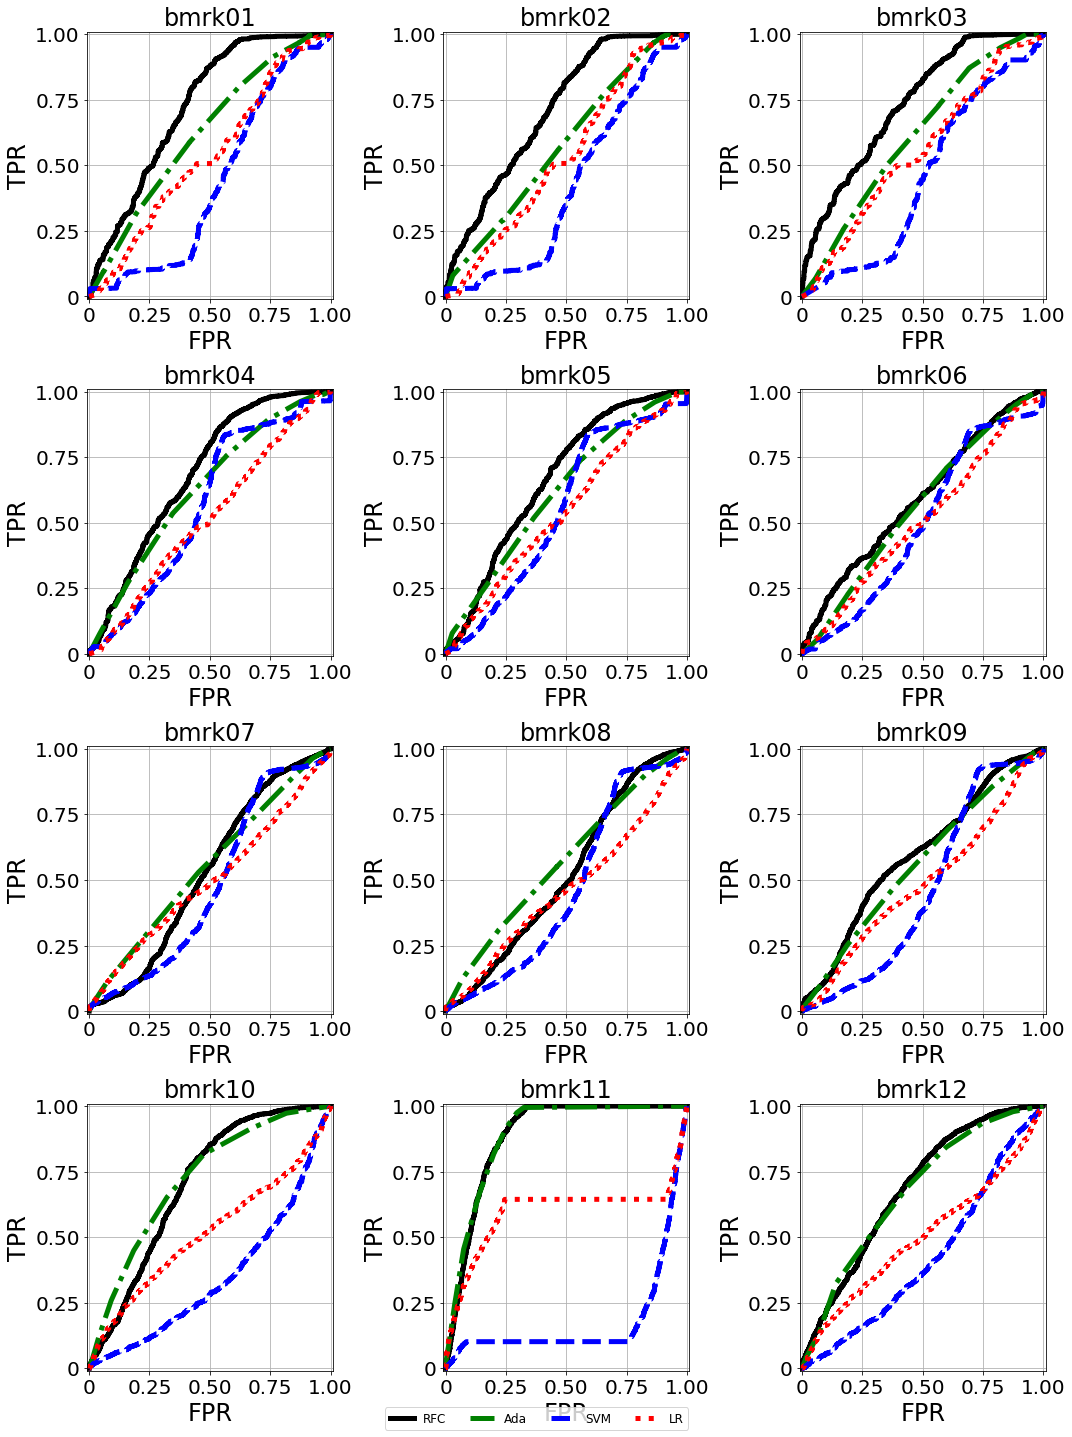

In [42]:
if 1 == 1:    
    fig, ax = plt.subplots(4, 3)
    fig.set_size_inches(15, 20)
    for iterator in range(len(bnchmrk_names_list)):
        pat_id = bnchmrk_names_list[iterator]
        ii = iterator//3
        jj = iterator%3
        pat_key = f"{pat_id:s}"
        ### print(f"*********************** {pat_key} ***********************")
        ### print(f"Processing {pat_key}", end ="\r")
        #fpr_list_extra = res_dict_tst_bag["fpr_list"][iterator]
        #tpr_list_extra = res_dict_tst_bag["tpr_list"][iterator]
        fpr_list_extra = res_dict_tst_rfc["fpr_list"][iterator]
        tpr_list_extra = res_dict_tst_rfc["tpr_list"][iterator]
        fpr_list_train = res_dict_tst_ada["fpr_list"][iterator]
        tpr_list_train = res_dict_tst_ada["tpr_list"][iterator]
        fpr_list_valid = res_dict_tst_svm["fpr_list"][iterator]
        tpr_list_valid = res_dict_tst_svm["tpr_list"][iterator]
        fpr_list_tests = res_dict_tst_log["fpr_list"][iterator]
        tpr_list_tests = res_dict_tst_log["tpr_list"][iterator]
        ax[ii, jj].plot(fpr_list_extra, tpr_list_extra, 'k-', linewidth = 5.0)
        ax[ii, jj].plot(fpr_list_train, tpr_list_train, 'g-.', linewidth = 5.0)
        ax[ii, jj].plot(fpr_list_valid, tpr_list_valid, 'b--', linewidth = 5.0)
        ax[ii, jj].plot(fpr_list_tests, tpr_list_tests, 'r:', linewidth = 5.0)
        ax[ii, jj].set_title(f'{pat_key}', fontsize = 24)
        ax[ii, jj].set_xlabel('FPR', fontsize = 24)
        ax[ii, jj].set_ylabel('TPR', fontsize = 24)
        ax[ii,jj].set_xlim([0-0.01,1+0.01])
        ax[ii,jj].set_xticks([0, 0.25, 0.50, 0.75, 1.00])
        ax[ii,jj].set_xticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 20)
        #ax[ii,jj].set_ylim([0.50-0.01,1+0.01])
        #ax[ii,jj].set_yticks([0.50, 0.75, 1.00], fontsize = "large")
        #ax[ii,jj].set_yticklabels(["0.50", "0.75", "1.00"], fontsize = 24)
        ax[ii,jj].set_ylim([0-0.01,1+0.01])
        ax[ii,jj].set_yticks([0, 0.25, 0.50, 0.75, 1.00], fontsize = "large")
        ax[ii,jj].set_yticklabels(["0", "0.25", "0.50", "0.75", "1.00"], fontsize = 20)
        ax[ii, jj].grid()
    #plt.rcParams.update({'font.size': 24})
    print()
    print("ROC curves:")
    #ax[ii, jj].legend(["Train", "Valid", "Test"], loc = 'lower right')
    plt.figlegend(["RFC", "Ada", "SVM", "LR"], loc = 8, ncol=5, labelspacing=0.,
                  bbox_to_anchor=(0.25, -0.0, 0.5, 0.5),  fontsize = 12)
    fig.tight_layout()
    #plt.savefig(fname = "fig03_roc_curves_v01.eps", dpi=300)
    plt.savefig(fname = "mlspred_roc_curves_reeg_v01.jpg", dpi=300)
    plt.show()